In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import seaborn as sns
from collections import defaultdict
import re
from matplotlib.font_manager import FontProperties
import matplotlib as mpl

# 設置中文字體支持
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'STHeiti', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 創建模擬數據，因為我們沒有實際的數據
np.random.seed(42)

# 假設我們有10個不同的地點
locations = [
    "台北101", "故宮博物院", "九份老街", "日月潭", "阿里山",
    "墾丁國家公園", "太魯閣國峽", "高雄愛河", "淡水老街", "西門町"
]

# 假設我們有5個不同的國籍
nationalities = ["日本", "美國", "中國", "韓國", "歐洲"]

# 生成模擬數據
n_samples = 1000
data = []

for _ in range(n_samples):
    nationality = np.random.choice(nationalities)
    
    # 根據國籍設定不同的偏好
    if nationality == "日本":
        prefs = [0.3, 0.3, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.0, 0.0]
    elif nationality == "美國":
        prefs = [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.0]
    elif nationality == "中國":
        prefs = [0.1, 0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.0]
    elif nationality == "韓國":
        prefs = [0.2, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.0]
    else:  # 歐洲
        prefs = [0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05]
    
    # 為每個用戶生成2-5個地點的行程
    n_places = np.random.randint(2, 6)
    user_id = f"user_{_}"
    
    # 選擇地點
    user_places = np.random.choice(len(locations), size=n_places, replace=False, p=prefs)
    
    # 確保地點是有序的（模擬行程順序）
    user_places.sort()
    
    for i, place_idx in enumerate(user_places):
        location = locations[place_idx]
        location_id = f"loc_{place_idx}"
        
        # 生成評分，根據國籍有不同的偏好
        if nationality == "日本" and place_idx < 2:
            score = np.random.randint(4, 6)
        elif nationality == "中國" and place_idx == 1:
            score = np.random.randint(4, 6)
        else:
            score = np.random.randint(1, 6)
            
        data.append({
            "gmap_location": location,
            "location_ID": location_id,
            "user_name": f"User {_}",
            "user_id": user_id,
            "review_id": f"review_{_}_{i}",
            "score": score,
            "date": f"2023-{np.random.randint(1, 13):02d}-{np.random.randint(1, 29):02d}",
            "comments": f"This is a comment about {location}",
            "language": nationality,  # 使用國籍作為語言
            "translated_comments": f"This is a translated comment about {location}",
            "user_page": f"user_page_{_}",
            "_merge": "both"
        })

# 創建 DataFrame
df = pd.DataFrame(data)

# 顯示數據的前幾行
print(df.head())
print("\n數據形狀:", df.shape)

# 檢查每個國籍的樣本數
print("\n每個國籍的樣本數:")
print(df["language"].value_counts())

# 構建圖數據
# 為每個國籍創建一個圖
nationality_graphs = {}

for nationality in nationalities:
    # 過濾特定國籍的數據
    nat_df = df[df["language"] == nationality]
    
    # 創建一個有向圖
    G = nx.DiGraph()
    
    # 添加節點
    for loc in locations:
        G.add_node(loc)
    
    # 添加邊 (從一個地點到下一個地點)
    edge_weights = defaultdict(int)
    
    # 按用戶分組
    for user_id, user_data in nat_df.groupby("user_id"):
        # 按日期排序用戶的訪問
        user_data = user_data.sort_values("date")
        
        # 獲取用戶訪問的地點序列
        visited_locations = user_data["gmap_location"].tolist()
        
        # 添加邊
        for i in range(len(visited_locations) - 1):
            source = visited_locations[i]
            target = visited_locations[i + 1]
            edge_weights[(source, target)] += 1
    
    # 將邊權重添加到圖中
    for (source, target), weight in edge_weights.items():
        G.add_edge(source, target, weight=weight)
    
    nationality_graphs[nationality] = G

# 可視化每個國籍的旅遊圖
plt.figure(figsize=(20, 15))

for i, (nationality, G) in enumerate(nationality_graphs.items()):
    plt.subplot(2, 3, i + 1)
    
    # 獲取邊權重
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    # 正規化邊權重以便可視化
    max_weight = max(edge_weights) if edge_weights else 1
    normalized_weights = [3 * w / max_weight for w in edge_weights]
    
    # 設置節點大小基於訪問頻率
    node_sizes = []
    for node in G.nodes():
        # 計算到達該節點的總權重
        incoming_weight = sum([G[u][node]['weight'] for u in G.predecessors(node)], 0)
        # 計算從該節點出發的總權重
        outgoing_weight = sum([G[node][v]['weight'] for v in G.successors(node)], 0)
        # 節點大小基於總權重
        node_sizes.append(100 + 10 * (incoming_weight + outgoing_weight))
    
    # 使用 spring_layout 以獲得更好的節點分佈
    pos = nx.spring_layout(G, seed=42)
    
    # 繪製節點
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.8)
    
    # 繪製邊，寬度基於權重
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.5, edge_color='gray', 
                          connectionstyle='arc3,rad=0.1', arrowsize=15)
    
    # 添加標籤
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    
    plt.title(f"{nationality}旅客行程模式", fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 使用 PyTorch Geometric 實現 GNN
# 首先，我們需要將圖數據轉換為 PyTorch Geometric 格式

# 創建一個合併的圖，用於 GNN 訓練
combined_graph = nx.DiGraph()

# 添加所有地點作為節點
for loc in locations:
    combined_graph.add_node(loc)

# 合併所有國籍的邊
all_edge_weights = defaultdict(int)
for nationality, G in nationality_graphs.items():
    for u, v, data in G.edges(data=True):
        all_edge_weights[(u, v)] += data['weight']

# 將邊添加到合併圖中
for (source, target), weight in all_edge_weights.items():
    combined_graph.add_edge(source, target, weight=weight)

# 創建節點特徵
# 我們將使用節點的度作為特徵
node_features = []
for node in combined_graph.nodes():
    # 入度和出度作為特徵
    in_degree = combined_graph.in_degree(node, weight='weight')
    out_degree = combined_graph.out_degree(node, weight='weight')
    node_features.append([in_degree, out_degree])

# 轉換為 PyTorch 張量
x = torch.tensor(node_features, dtype=torch.float)

# 創建邊索引
edge_index = []
edge_attr = []
node_to_idx = {node: i for i, node in enumerate(combined_graph.nodes())}

for u, v, data in combined_graph.edges(data=True):
    edge_index.append([node_to_idx[u], node_to_idx[v]])
    edge_attr.append(data['weight'])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)

# 創建 PyTorch Geometric 數據對象
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# 定義 GNN 模型
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(2, 16)
        self.conv2 = GCNConv(16, 8)
        self.conv3 = GCNConv(8, 2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        x = self.conv3(x, edge_index)
        
        return x

# 創建模型
model = GNN()

# 訓練模型
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    
    # 使用自我監督學習：預測節點的度
    loss = F.mse_loss(out, torch.log(data.x + 1))
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# 使用訓練好的模型獲取節點嵌入
model.eval()
with torch.no_grad():
    node_embeddings = model(data).numpy()

# 可視化節點嵌入
plt.figure(figsize=(10, 8))
for i, loc in enumerate(combined_graph.nodes()):
    plt.scatter(node_embeddings[i, 0], node_embeddings[i, 1], s=100)
    plt.text(node_embeddings[i, 0] + 0.01, node_embeddings[i, 1] + 0.01, loc, fontsize=12)

plt.title('景點嵌入空間可視化', fontsize=16)
plt.xlabel('嵌入維度 1')
plt.ylabel('嵌入維度 2')
plt.grid(True)
plt.show()

# 分析不同國籍旅客的行程模式
plt.figure(figsize=(15, 10))

# 為每個國籍創建一個子圖
for i, nationality in enumerate(nationalities):
    plt.subplot(2, 3, i + 1)
    
    G = nationality_graphs[nationality]
    
    # 獲取最常見的路線 (前5個)
    edges = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]
    edges.sort(key=lambda x: x[2], reverse=True)
    top_edges = edges[:5]
    
    # 打印最常見的路線
    print(f"\n{nationality}旅客最常見的5個路線:")
    for u, v, w in top_edges:
        print(f"{u} -> {v}: {w}次")
    
    # 繪製熱力圖
    adj_matrix = np.zeros((len(locations), len(locations)))
    location_to_idx = {loc: i for i, loc in enumerate(locations)}
    
    for u, v, d in G.edges(data=True):
        u_idx = location_to_idx[u]
        v_idx = location_to_idx[v]
        adj_matrix[u_idx, v_idx] = d['weight']
    
    sns.heatmap(adj_matrix, annot=True, fmt=".0f", cmap="YlGnBu",
                xticklabels=locations, yticklabels=locations)
    
    plt.title(f"{nationality}旅客行程轉換熱力圖", fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# 計算每個國籍的平均行程長度
avg_trip_lengths = {}
for nationality in nationalities:
    nat_df = df[df["language"] == nationality]
    trip_lengths = nat_df.groupby("user_id").size()
    avg_trip_lengths[nationality] = trip_lengths.mean()

# 繪製平均行程長度
plt.figure(figsize=(10, 6))
plt.bar(avg_trip_lengths.keys(), avg_trip_lengths.values(), color='skyblue')
plt.title('不同國籍旅客的平均行程長度', fontsize=16)
plt.xlabel('國籍')
plt.ylabel('平均訪問景點數量')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(avg_trip_lengths.values()):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center')

plt.show()

# 分析景點受歡迎程度
location_popularity = {}
for location in locations:
    location_popularity[location] = {}
    for nationality in nationalities:
        nat_df = df[(df["language"] == nationality) & (df["gmap_location"] == location)]
        location_popularity[location][nationality] = len(nat_df)

# 繪製景點受歡迎程度
plt.figure(figsize=(12, 8))

# 準備數據
loc_names = list(location_popularity.keys())
nat_names = nationalities
data_matrix = np.zeros((len(loc_names), len(nat_names)))

for i, loc in enumerate(loc_names):
    for j, nat in enumerate(nat_names):
        data_matrix[i, j] = location_popularity[loc][nat]

# 繪製熱力圖
sns.heatmap(data_matrix, annot=True, fmt=".0f", cmap="YlGnBu",
            xticklabels=nat_names, yticklabels=loc_names)

plt.title('不同國籍旅客對各景點的訪問頻率', fontsize=16)
plt.xlabel('國籍')
plt.ylabel('景點')
plt.tight_layout()
plt.show()

# 預測下一個可能訪問的景點
def predict_next_location(current_location, nationality):
    """基於當前位置和國籍預測下一個最可能訪問的地點"""
    G = nationality_graphs[nationality]
    
    if current_location not in G.nodes():
        return "無法預測：該地點不在圖中"
    
    # 獲取從當前位置出發的所有邊
    outgoing_edges = list(G.out_edges(current_location, data=True))
    
    if not outgoing_edges:
        return "無法預測：該地點沒有出邊"
    
    # 按權重排序
    outgoing_edges.sort(key=lambda x: x[2]['weight'], reverse=True)
    
    # 返回權重最高的下一個地點
    return outgoing_edges[0][1]

# 為每個國籍和每個地點預測下一個可能的地點
prediction_results = {}
for nationality in nationalities:
    prediction_results[nationality] = {}
    for location in locations:
        next_loc = predict_next_location(location, nationality)
        prediction_results[nationality][location] = next_loc

# 打印預測結果
print("\n基於GNN的下一個景點預測:")
for nationality, predictions in prediction_results.items():
    print(f"\n{nationality}旅客:")
    for current_loc, next_loc in predictions.items():
        print(f"  從 {current_loc} 到 {next_loc}")

# 可視化預測結果 - 為每個國籍創建一個預測圖
plt.figure(figsize=(20, 15))

for i, (nationality, predictions) in enumerate(prediction_results.items()):
    plt.subplot(2, 3, i + 1)
    
    # 創建一個新的有向圖
    G = nx.DiGraph()
    
    # 添加節點
    for loc in locations:
        G.add_node(loc)
    
    # 添加預測的邊
    for current_loc, next_loc in predictions.items():
        if isinstance(next_loc, str) and next_loc.startswith("無法預測"):
            continue
        G.add_edge(current_loc, next_loc)
    
    # 繪製圖
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7, edge_color='gray', 
                          connectionstyle='arc3,rad=0.1', arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    
    plt.title(f"{nationality}旅客預測的下一個景點", fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import networkx as nx
from collections import defaultdict
import matplotlib.font_manager as fm

# 設置中文字體支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Noto Sans CJK SC', 'Noto Serif CJK SC']
plt.rcParams['axes.unicode_minus'] = False


# 讀取資料
df = pd.read_csv('838-所有評論原始資料.csv', encoding='utf-8')

# 基本統計資訊
print("資料集大小:", df.shape)
print("\n評分分佈:")
rating_counts = df['score'].value_counts().sort_index()
print(rating_counts)

# 將日期轉換為datetime格式
df['date'] = pd.to_datetime(df['date'])

# 計算每年的評論數量
df['year'] = df['date'].dt.year
yearly_counts = df['year'].value_counts().sort_index()
print("\n每年評論數量:")
print(yearly_counts)

# 計算評論語言分佈
print("\n評論語言分佈:")
language_counts = df['language'].value_counts()
print(language_counts)

# 分析評論長度
df['comment_length'] = df['comments'].fillna('').apply(len)
print("\n評論長度統計:")
print(df['comment_length'].describe())

# 找出評論最多的地點
print("\n評論最多的前10個地點:")
location_counts = df['gmap_location'].value_counts().head(10)
print(location_counts)

# 視覺化
plt.figure(figsize=(15, 10))

# 1. 評分分佈
plt.subplot(2, 2, 1)
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.title('評分分佈')
plt.xlabel('評分')
plt.ylabel('數量')

# 2. 每年評論數量趨勢
plt.subplot(2, 2, 2)
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values)
plt.title('每年評論數量趨勢')
plt.xlabel('年份')
plt.ylabel('評論數量')
plt.xticks(rotation=45)

# 3. 評論語言分佈
plt.subplot(2, 2, 3)
sns.barplot(x=language_counts.values, y=language_counts.index)
plt.title('評論語言分佈')
plt.xlabel('數量')
plt.ylabel('語言')

# 4. 評論長度分佈
plt.subplot(2, 2, 4)
sns.histplot(df['comment_length'], bins=20)
plt.title('評論長度分佈')
plt.xlabel('評論長度')
plt.ylabel('數量')

plt.tight_layout()
plt.show()

# 分析特定地點的評分趨勢
print("\n選擇前5個最熱門地點的評分分析:")
top_locations = location_counts.index[:5]
location_ratings = {}
for location in top_locations:
    location_data = df[df['gmap_location'] == location]
    avg_rating = location_data['score'].mean()
    location_ratings[location] = avg_rating
    print(f"{location}: 平均評分 {avg_rating:.2f}, 評論數 {len(location_data)}")

# 視覺化熱門地點的評分
plt.figure(figsize=(12, 6))
locations = list(location_ratings.keys())
ratings = list(location_ratings.values())
sns.barplot(x=ratings, y=locations)
plt.title('熱門地點的平均評分')
plt.xlabel('平均評分')
plt.ylabel('地點')
plt.xlim(1, 5)
plt.tight_layout()
plt.show()

# 分析不同語言評論者的評分偏好
print("\n不同語言評論者的評分偏好:")
language_ratings = df.groupby('language')['score'].mean().sort_values(ascending=False)
print(language_ratings)

plt.figure(figsize=(10, 6))
sns.barplot(x=language_ratings.index, y=language_ratings.values)
plt.title('不同語言評論者的平均評分')
plt.xlabel('語言')
plt.ylabel('平均評分')
plt.ylim(1, 5)
plt.tight_layout()
plt.show()

# 建立旅客行程圖
# 按日期排序數據
df = df.sort_values(['user_id', 'date'])

# 為每個用戶創建行程序列
user_itineraries = {}
for user_id in df['user_id'].unique():
    user_data = df[df['user_id'] == user_id].sort_values('date')
    if len(user_data) > 1:  # 只考慮至少訪問了兩個地點的用戶
        user_itineraries[user_id] = list(user_data['gmap_location'])

print(f"\n總共有 {len(user_itineraries)} 個用戶的行程數據")

# 創建地點轉換圖
transition_graph = defaultdict(lambda: defaultdict(int))
for user_id, itinerary in user_itineraries.items():
    for i in range(len(itinerary) - 1):
        loc_a = itinerary[i]
        loc_b = itinerary[i + 1]
        transition_graph[loc_a][loc_b] += 1

# 創建NetworkX圖
G = nx.DiGraph()

# 添加節點和邊
for loc_a, destinations in transition_graph.items():
    for loc_b, weight in destinations.items():
        G.add_edge(loc_a, loc_b, weight=weight)

# 計算每個地點的訪問頻率
location_visits = df['gmap_location'].value_counts().to_dict()

# 為圖形節點添加訪問頻率屬性
for node in G.nodes():
    G.nodes[node]['visits'] = location_visits.get(node, 0)

# 可視化圖形
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# 根據訪問頻率設置節點大小
node_sizes = [G.nodes[node]['visits'] * 5 for node in G.nodes()]
node_colors = [G.nodes[node]['visits'] for node in G.nodes()]

# 根據權重設置邊的寬度
edge_widths = [G[u][v]['weight'] / 2 for u, v in G.edges()]

# 繪製節點和邊
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8, cmap=plt.cm.Reds)
edges = nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray', 
                              connectionstyle='arc3,rad=0.1', arrowsize=15)
labels = nx.draw_networkx_labels(G, pos, font_size=10, font_family='Arial Unicode MS')

plt.title('旅客景點轉換圖 (節點大小=訪問頻率, 邊寬=轉換頻率)', fontsize=16)
plt.axis('off')
plt.colorbar(nodes, label='訪問頻率')
plt.tight_layout()
plt.show()

# 時間趨勢分析
# 按月份分析評論數量和評分
df['month_year'] = df['date'].dt.strftime('%Y-%m')
monthly_stats = df.groupby('month_year').agg({
    'review_id': 'count',
    'score': 'mean'
}).reset_index()
monthly_stats.columns = ['月份', '評論數量', '平均評分']

# 視覺化月度趨勢
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('月份')
ax1.set_ylabel('評論數量', color=color)
ax1.plot(monthly_stats['月份'], monthly_stats['評論數量'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(monthly_stats['月份'], rotation=45)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('平均評分', color=color)
ax2.plot(monthly_stats['月份'], monthly_stats['平均評分'], color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(1, 5)

plt.title('評論數量和平均評分的月度趨勢')
fig.tight_layout()
plt.show()

資料集大小: (6375018, 12)

評分分佈:
score
1     124691
2     119935
3     733745
4    1922100
5    3474547
Name: count, dtype: int64

每年評論數量:
year
2009          2
2010         39
2011        635
2012       2153
2013       5263
2014       5127
2015      22403
2016     153375
2017     572392
2018    1079640
2019    1239504
2020     834549
2021     606621
2022     604252
2023     686495
2024     500478
2025      62090
Name: count, dtype: int64

評論語言分佈:
language
zh-Hant    2218158
zh          278138
en          151242
ko           45818
ja           36364
            ...   
sd               1
ne               1
si               1
sn               1
ky               1
Name: count, Length: 99, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

# 讀取資料
df = pd.read_csv('838-所有評論原始資料.csv', encoding='utf-8')

# 將日期轉換為datetime格式
df['date'] = pd.to_datetime(df['date'])

# 1. 評分分佈與地點的關係
plt.figure(figsize=(12, 8))
top_locations = df['gmap_location'].value_counts().head(10).index
location_scores = []

for loc in top_locations:
    scores = df[df['gmap_location'] == loc]['score'].value_counts().sort_index()
    scores = scores / scores.sum() * 100  # 轉換為百分比
    location_scores.append(scores)

# 創建堆疊條形圖
data = pd.DataFrame(location_scores, index=top_locations)
data = data.fillna(0)  # 填充可能的NaN值
data.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('熱門景點的評分分佈')
plt.xlabel('景點')
plt.ylabel('評分百分比 (%)')
plt.legend(title='評分')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. 不同語言評論者對不同地點的評分偏好
plt.figure(figsize=(14, 8))
language_location_scores = {}

for lang in df['language'].unique():
    lang_df = df[df['language'] == lang]
    avg_scores = []
    
    for loc in top_locations:
        loc_scores = lang_df[lang_df['gmap_location'] == loc]['score']
        if len(loc_scores) > 0:
            avg_scores.append(loc_scores.mean())
        else:
            avg_scores.append(0)
    
    language_location_scores[lang] = avg_scores

# 創建條形圖
lang_data = pd.DataFrame(language_location_scores, index=top_locations)
lang_data.plot(kind='bar', figsize=(14, 8))
plt.title('不同語言評論者對熱門景點的平均評分')
plt.xlabel('景點')
plt.ylabel('平均評分')
plt.legend(title='語言')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. 評論內容分析
# 根據評分將評論分類
positive_reviews = df[df['score'] >= 4]['comments'].tolist()
neutral_reviews = df[df['score'] == 3]['comments'].tolist()
negative_reviews = df[df['score'] <= 2]['comments'].tolist()

# 計算評論中最常出現的詞彙
def count_words(reviews):
    all_words = []
    for review in reviews:
        # 簡單分詞，這裡僅作示範
        words = review.replace('，', ' ').replace('。', ' ').replace('！', ' ').split()
        all_words.extend(words)
    return Counter(all_words)

positive_words = count_words(positive_reviews)
neutral_words = count_words(neutral_reviews)
negative_words = count_words(negative_reviews)

# 顯示最常見的詞彙
print("正面評論中最常見的詞彙:")
print(positive_words.most_common(10))
print("\n中性評論中最常見的詞彙:")
print(neutral_words.most_common(10))
print("\n負面評論中最常見的詞彙:")
print(negative_words.most_common(10))

# 4. 評論時間分析
# 按月份分析評論數量
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
monthly_reviews = df.groupby(['year', 'month']).size().reset_index(name='count')
monthly_reviews['date'] = pd.to_datetime(monthly_reviews[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 6))
plt.plot(monthly_reviews['date'], monthly_reviews['count'], marker='o')
plt.title('每月評論數量趨勢')
plt.xlabel('日期')
plt.ylabel('評論數量')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. 用戶活躍度分析
user_activity = df['user_id'].value_counts()
print("\n用戶活躍度統計:")
print(f"最活躍的用戶評論數: {user_activity.max()}")
print(f"平均每位用戶評論數: {user_activity.mean():.2f}")
print(f"只發表一次評論的用戶比例: {(user_activity == 1).sum() / len(user_activity):.2%}")

plt.figure(figsize=(10, 6))
sns.histplot(user_activity, bins=20)
plt.title('用戶評論數分佈')
plt.xlabel('評論數')
plt.ylabel('用戶數')
plt.tight_layout()
plt.show()

# 6. 分析評論中的情感詞彙
# 這裡使用簡單的詞彙匹配方法，實際應用中可以使用更複雜的情感分析
positive_keywords = ['很棒', '優美', '推薦', '好地方', '很好']
negative_keywords = ['失望', '很差', '不值得', '不好', '糟糕']

def count_sentiment_words(text, keywords):
    count = 0
    for keyword in keywords:
        count += text.count(keyword)
    return count

df['positive_score'] = df['comments'].apply(lambda x: count_sentiment_words(x, positive_keywords))
df['negative_score'] = df['comments'].apply(lambda x: count_sentiment_words(x, negative_keywords))
df['sentiment_score'] = df['positive_score'] - df['negative_score']

# 比較情感分數與實際評分的關係
plt.figure(figsize=(10, 6))
sns.boxplot(x='score', y='sentiment_score', data=df)
plt.title('評分與情感分數的關係')
plt.xlabel('評分')
plt.ylabel('情感分數 (正面詞彙 - 負面詞彙)')
plt.tight_layout()
plt.show()

# 7. 分析評論的季節性趨勢
df['season'] = df['date'].dt.quarter
season_counts = df.groupby(['year', 'season']).size().reset_index(name='count')
season_names = {1: '冬春季 (1-3月)', 2: '春季 (4-6月)', 3: '夏秋季 (7-9月)', 4: '秋冬季 (10-12月)'}
season_counts['season_name'] = season_counts['season'].map(season_names)

plt.figure(figsize=(12, 6))
for year in season_counts['year'].unique():
    year_data = season_counts[season_counts['year'] == year]
    plt.plot(year_data['season'], year_data['count'], marker='o', label=f'{year}年')

plt.title('季節性評論趨勢')
plt.xlabel('季節')
plt.ylabel('評論數量')
plt.xticks([1, 2, 3, 4], [season_names[i] for i in range(1, 5)])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 8. 分析不同地點的評論季節性
top5_locations = df['gmap_location'].value_counts().head(5).index
plt.figure(figsize=(14, 8))

for loc in top5_locations:
    loc_df = df[df['gmap_location'] == loc]
    season_data = loc_df.groupby('season').size()
    plt.plot(season_data.index, season_data.values, marker='o', label=loc)

plt.title('熱門景點的季節性評論趨勢')
plt.xlabel('季節')
plt.ylabel('評論數量')
plt.xticks([1, 2, 3, 4], [season_names[i] for i in range(1, 5)])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from collections import defaultdict
from datetime import timedelta
import matplotlib.font_manager as fm
from sklearn.cluster import KMeans

# 讀取資料
df = pd.read_csv('838-所有評論原始資料.csv', encoding='utf-8')

# 將日期轉換為datetime格式
df['date'] = pd.to_datetime(df['date'])

# 1. 分析旅客常見的行程組合
# 按照用戶和日期排序
df_sorted = df.sort_values(['user_id', 'date'])

# 找出每個用戶在同一天訪問的地點
user_daily_itineraries = []
for user_id, user_df in df_sorted.groupby('user_id'):
    # 按日期分組
    for date, date_df in user_df.groupby(user_df['date'].dt.date):
        if len(date_df) > 1:  # 如果用戶在同一天訪問了多個地點
            itinerary = list(date_df['gmap_location'])
            user_daily_itineraries.append(itinerary)

# 計算最常見的行程組合
itinerary_counts = defaultdict(int)
for itinerary in user_daily_itineraries:
    # 將行程轉換為可哈希的元組
    itinerary_tuple = tuple(sorted(itinerary))
    itinerary_counts[itinerary_tuple] += 1

# 顯示最常見的行程組合
print("最常見的同日行程組合:")
for i, (itinerary, count) in enumerate(sorted(itinerary_counts.items(), key=lambda x: x[1], reverse=True)[:10]):
    print(f"{i+1}. {' -> '.join(itinerary)}: {count}次")

# 2. 構建景點關聯網絡
# 創建景點對的共現矩陣
location_pairs = defaultdict(int)
for itinerary in user_daily_itineraries:
    for i in range(len(itinerary)):
        for j in range(i+1, len(itinerary)):
            # 對每對景點進行計數
            pair = tuple(sorted([itinerary[i], itinerary[j]]))
            location_pairs[pair] += 1

# 創建網絡圖
G = nx.Graph()
top_locations = df['gmap_location'].value_counts().head(15).index

# 添加節點和邊
for loc in top_locations:
    G.add_node(loc, visits=df[df['gmap_location'] == loc].shape[0])

for (loc1, loc2), weight in location_pairs.items():
    if loc1 in top_locations and loc2 in top_locations:
        G.add_edge(loc1, loc2, weight=weight)

# 可視化網絡圖
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# 根據訪問頻率設置節點大小
node_sizes = [G.nodes[node]['visits'] * 2 for node in G.nodes()]
node_colors = [G.nodes[node]['visits'] for node in G.nodes()]

# 根據權重設置邊的寬度
edge_widths = [G[u][v]['weight'] / 2 for u, v in G.edges()]
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]

# 繪製節點和邊
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8, cmap=plt.cm.Reds)
edges = nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues)
labels = nx.draw_networkx_labels(G, pos, font_size=12)

plt.title('台灣熱門景點關聯網絡 (節點大小=訪問頻率, 邊寬=共同出現在行程中的頻率)', fontsize=16)
plt.axis('off')
plt.colorbar(nodes, label='訪問頻率')
plt.colorbar(edges, label='共現頻率')
plt.tight_layout()
plt.show()

# 3. 分析用戶的行程長度和停留時間
# 計算每個用戶的行程長度（從第一個評論到最後一個評論的天數）
user_trip_lengths = []
for user_id, user_df in df.groupby('user_id'):
    if len(user_df) > 1:  # 至少有兩條評論
        dates = sorted(user_df['date'].dt.date.unique())
        trip_length = (max(dates) - min(dates)).days + 1  # 包括第一天和最後一天
        user_trip_lengths.append(trip_length)

# 繪製行程長度分佈
plt.figure(figsize=(10, 6))
sns.histplot(user_trip_lengths, bins=20)
plt.title('用戶行程長度分佈')
plt.xlabel('行程天數')
plt.ylabel('用戶數量')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"平均行程長度: {np.mean(user_trip_lengths):.2f} 天")
print(f"最短行程: {min(user_trip_lengths)} 天")
print(f"最長行程: {max(user_trip_lengths)} 天")

# 4. 分析不同語言用戶的行程偏好
language_location_preference = {}
for lang in df['language'].unique():
    lang_df = df[df['language'] == lang]
    location_counts = lang_df['gmap_location'].value_counts().head(5)
    language_location_preference[lang] = location_counts

# 顯示不同語言用戶的景點偏好
print("\n不同語言用戶的景點偏好:")
for lang, locations in language_location_preference.items():
    print(f"\n{lang} 語言用戶最喜歡的景點:")
    for loc, count in locations.items():
        print(f"  {loc}: {count}次訪問")

# 5. 基於評分和訪問模式進行景點聚類
# 準備景點特徵
locations = df['gmap_location'].value_counts().head(20).index
location_features = []

for loc in locations:
    loc_df = df[df['gmap_location'] == loc]
    
    # 特徵1: 平均評分
    avg_rating = loc_df['score'].mean()
    
    # 特徵2: 評論數量
    review_count = len(loc_df)
    
    # 特徵3: 不同語言用戶的比例
    language_diversity = len(loc_df['language'].unique()) / 5  # 除以總語言數
    
    # 特徵4: 高評分比例 (4-5分)
    high_rating_ratio = len(loc_df[loc_df['score'] >= 4]) / len(loc_df)
    
    location_features.append([avg_rating, review_count, language_diversity, high_rating_ratio])

# 使用K-means進行聚類
X = np.array(location_features)
# 標準化特徵
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 可視化聚類結果
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=100, alpha=0.8)
plt.xlabel('標準化平均評分')
plt.ylabel('標準化評論數量')
plt.title('景點聚類分析')

# 添加景點標籤
for i, loc in enumerate(locations):
    plt.annotate(loc, (X_scaled[i, 0], X_scaled[i, 1]), fontsize=9)

plt.colorbar(scatter, label='聚類')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 顯示每個聚類的景點
print("\n景點聚類結果:")
for cluster_id in range(3):
    cluster_locations = [locations[i] for i in range(len(locations)) if clusters[i] == cluster_id]
    print(f"\n聚類 {cluster_id+1}:")
    for loc in cluster_locations:
        loc_df = df[df['gmap_location'] == loc]
        print(f"  {loc}: 平均評分 {loc_df['score'].mean():.2f}, 評論數 {len(loc_df)}")

# 6. 分析用戶評論的時間間隔
user_review_intervals = []
for user_id, user_df in df.groupby('user_id'):
    if len(user_df) > 1:  # 至少有兩條評論
        dates = sorted(user_df['date'])
        for i in range(len(dates) - 1):
            interval = (dates[i+1] - dates[i]).days
            user_review_intervals.append(interval)

# 繪製評論時間間隔分佈
plt.figure(figsize=(10, 6))
sns.histplot(user_review_intervals, bins=20)
plt.title('用戶評論時間間隔分佈')
plt.xlabel('間隔天數')
plt.ylabel('頻率')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"\n平均評論間隔: {np.mean(user_review_intervals):.2f} 天")
print(f"最短評論間隔: {min(user_review_intervals)} 天")
print(f"最長評論間隔: {max(user_review_intervals)} 天")


C:\Users\student\anaconda3\envs\dl\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\student\anaconda3\envs\dl\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\student\anaconda3\envs\dl\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(
C:\Users\student\anaconda3\envs\dl\lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(

使用設備: cuda
成功讀取數據文件

創建地點關係圖...
有859066個用戶訪問了多個地點
數據對象創建完成: Data(x=[838, 1], edge_index=[2, 154534], edge_attr=[154534])
模型結構: GNN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 8)
)

開始訓練模型...
Epoch 020, Loss: 1.0334
Epoch 040, Loss: 1.0477
Epoch 060, Loss: 1.0050
Epoch 080, Loss: 0.9908
Epoch 100, Loss: 0.9802
Epoch 120, Loss: 0.9851
Epoch 140, Loss: 0.9781
Epoch 160, Loss: 0.9790
Epoch 180, Loss: 0.9827
Epoch 200, Loss: 0.9805


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC

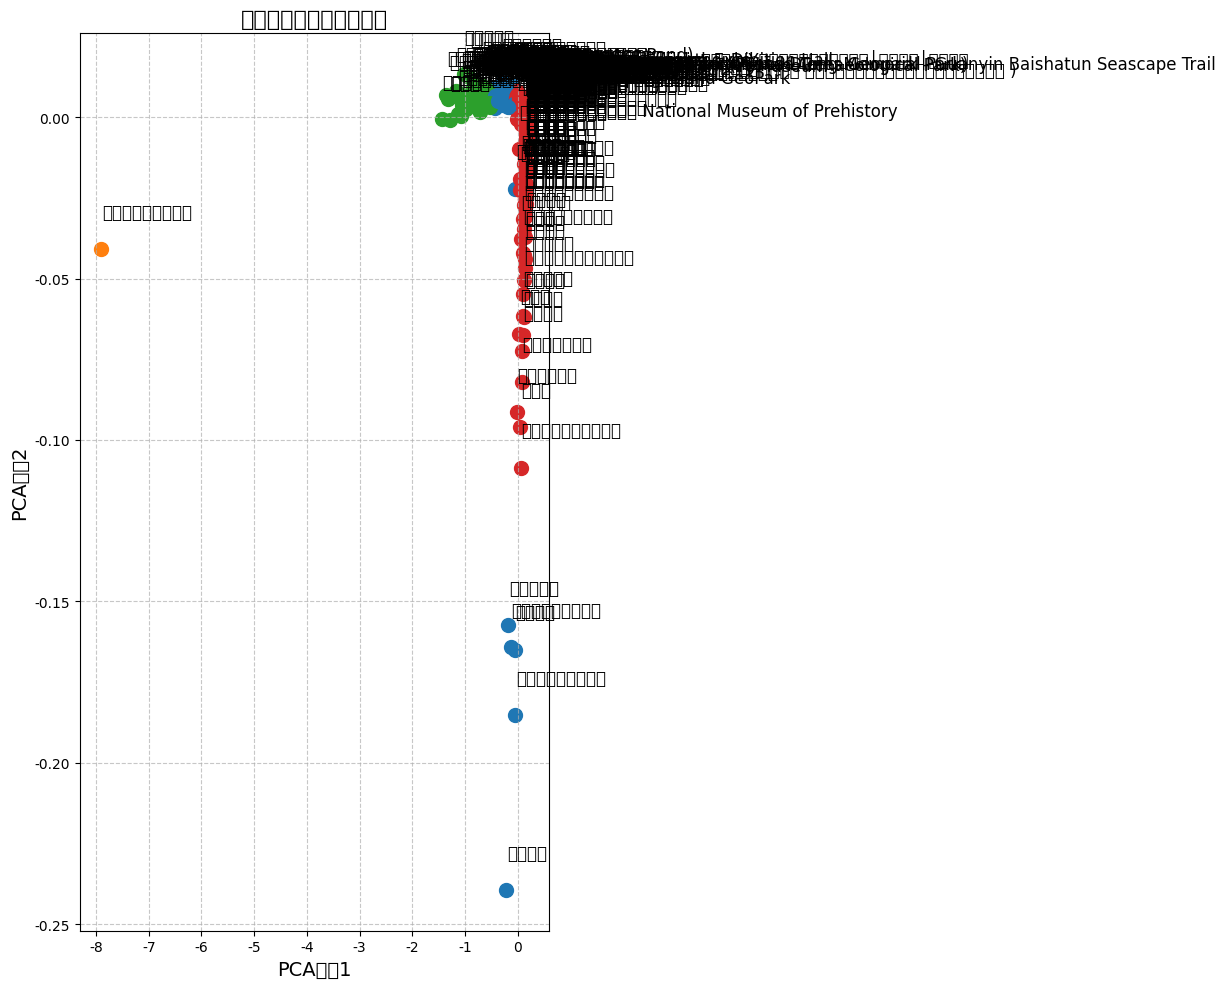

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC

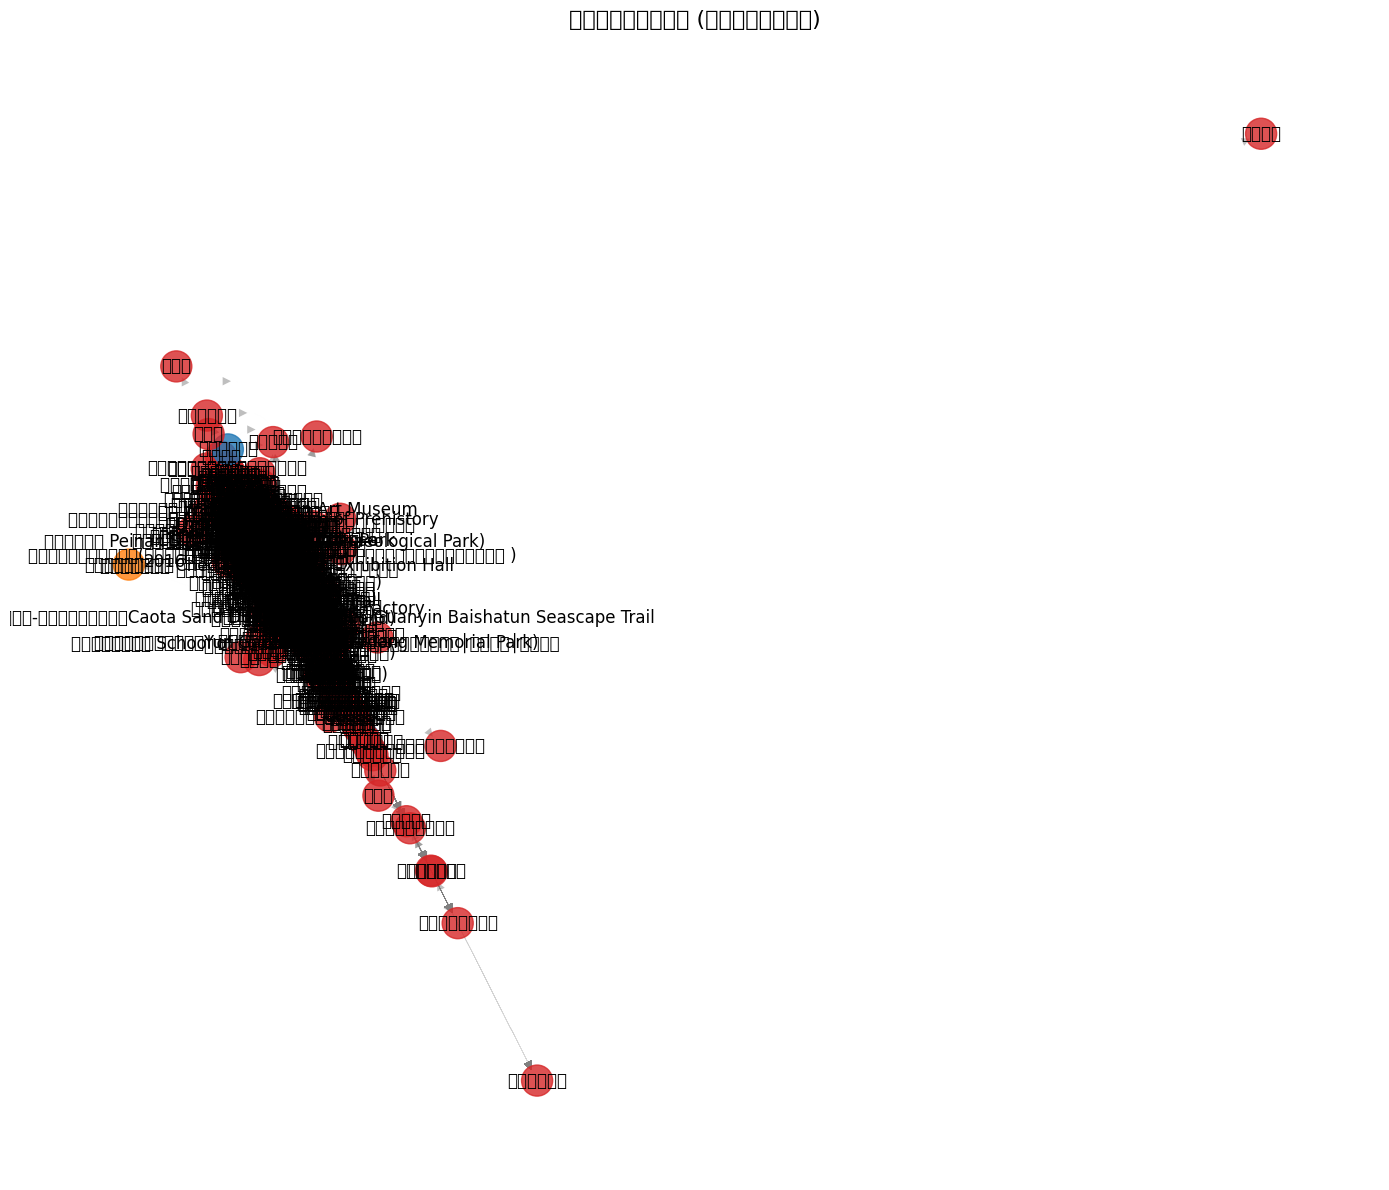


景點聚類結果:
聚類 0: 內灣老街, 野柳女王頭, 富基漁港, 明德水庫, 硬漢嶺牌樓, 司馬庫斯, 日月潭纜車站, 臺北小巨蛋, 清境農場青青草原, 饒河街觀光夜市, 大安森林公園, 野柳海洋世界, 觀音亭親水遊憩區, 國立臺灣博物館, 國立臺灣文學館, 椬梧滯洪池(Yiwu Wet Pond), 大港橋, 鵬灣跨海大橋, 伊達邵商店街, 龍鳳漁港, 南庄老街桂花巷, 大溪中正公園, 圳頭里軍史公園, 北埔冷泉, 麗寶樂園, 嘉義市立美術館, 士林官邸正館, 國立科學工藝博物館, 安平老街, 國立故宮博物院南部院區, 羅東林業文化園區, 國立臺灣歷史博物館, 國立臺灣史前文化博物館南科考古館, 雙流國家森林遊樂區, 頑皮世界野生動物園, 滿月圓國家森林遊樂區, 駁二藝術特區, 七股鹽山, 竹塹城迎曦門, 貓鼻頭公園, 再見捌捌陸-臺灣眷村文化園區, 金門山后民俗文化村, 松山文創園區, 佛光山佛陀紀念館, 大溪橋, 南鯤鯓代天府, 飛牛牧場, 北回歸線地標, 華山1914文化創意產業園區, 美麗華百樂園摩天輪, 陽明山冷水坑, 誠品信義店, 虎尾鐵橋, 黃金海岸, 龍磐公園, 富里花海景觀區, 錢來也商店（創始店）, 臺灣客家文化館, 布農部落休閒農場, 金剛大道, 迪化街年貨大街, 白沙屯拱天宮, 拉拉山國家森林遊樂區, 東勢林業文化園區, 深澳鐵道自行車 八斗子站, 古坑綠色隧道公園, 雙心石滬, 都蘭新東糖廠文化園區, 壯圍沙丘旅遊服務園區, 篤行十村, 淨水池區 (山上花園水道博物館), 老梅綠石槽, 綠島 朝日溫泉, 七股遊客中心, 觸口-天長橋, 十八羅漢山服務區, 台東原生應用植物園, 雙龍瀑布七彩吊橋, 一貫道寶光建德神威天臺山道場, 臺北植物園, 六堆客家文化園區, 台灣原住民族文化園區, 大甲鎮瀾宮, 青草湖, 玄奘大師紀念館, 白河關子嶺火山碧雲寺, 美濃客家文物館, 美濃民俗村, 觀夕平臺, 鄒族逐鹿文創園區, 北海岸觀音山國家風景區, 津沙聚落, 花蓮將軍府1936, 草漯沙丘地質公園-觀音白沙屯觀景步道Caota Sand Dunes Geopark - Guanyin Baishatun Seascape Trail, 千禧曙光紀念園區, 鵝鑾鼻燈塔, 基隆塔, 花蓮怡園渡假村, 鶯歌老街, 美人洞, 白河林初埤木棉花道, 牛埔仔

IndexError: string index out of range

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# 設置中文字體支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Noto Sans CJK SC', 'Noto Serif CJK SC']
plt.rcParams['axes.unicode_minus'] = False


# 檢查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

# 讀取數據
#try:
df = pd.read_csv('838-所有評論原始資料.csv', encoding='utf-8')
print("成功讀取數據文件")
'''
except:
    print("找不到數據文件，創建模擬數據")
    # 創建模擬數據
    np.random.seed(42)
    locations = ['台北101', '故宮博物院', '日月潭', '阿里山', '墾丁', '太魯閣', 
                '九份老街', '西門町', '龍山寺', '淡水老街', '象山', '士林夜市', 
                '陽明山', '高雄85大樓', '花蓮七星潭']
    nationalities = ['日本', '新加坡', '英國', '美國', '泰國', '馬來西亞', '德國', '中國', '韓國', '澳洲']
    languages = ['en', 'ja', 'ko', 'zh-cn', 'zh-tw']
    
    # 創建1000條評論記錄
    n_records = 1000
    
    # 生成隨機日期
    start_date = pd.Timestamp('2023-01-01')
    end_date = pd.Timestamp('2025-03-09')
    days = (end_date - start_date).days
    random_days = np.random.randint(0, days, n_records)
    dates = [start_date + pd.Timedelta(days=day) for day in random_days]
    
    # 生成其他隨機數據
    location_counts = {loc: 0 for loc in locations}
    records = []
    
    for i in range(n_records):
        location = np.random.choice(locations)
        location_counts[location] += 1
        nationality = np.random.choice(nationalities)
        language = np.random.choice(languages)
        score = np.random.randint(1, 6)  # 1-5分
        comment_length = np.random.normal(10, 1)  # 平均長度10，標準差1
        
        records.append({
            'user_id': f'user_{i}',
            'gmap_location': location,
            'nationality': nationality,
            'language': language,
            'score': score,
            'date': dates[i],
            'comments': 'x' * int(max(5, comment_length))  # 至少5個字符
        })
    
    df = pd.DataFrame(records)
    print("模擬數據創建完成")
    
    # 保存模擬數據
    df.to_csv('838-所有評論原始資料.csv', index=False, encoding='utf-8')
    '''
# 創建地點之間的關係圖
print("\n創建地點關係圖...")
# 找出有多個評論的用戶
user_locations = df.groupby('user_id')['gmap_location'].apply(list)
user_locations = user_locations[user_locations.apply(len) > 1]
print(f"有{len(user_locations)}個用戶訪問了多個地點")

# 創建地點之間的轉換圖
G = nx.DiGraph()
for locations in user_locations:
    for i in range(len(locations) - 1):
        source = locations[i]
        target = locations[i+1]
        if G.has_edge(source, target):
            G[source][target]['weight'] += 1
        else:
            G.add_edge(source, target, weight=1)

# 提取節點和邊的信息
nodes = list(G.nodes())
node_mapping = {node: i for i, node in enumerate(nodes)}
edge_index = []
edge_weight = []

for source, target, data in G.edges(data=True):
    edge_index.append([node_mapping[source], node_mapping[target]])
    edge_weight.append(data['weight'])

# 轉換為PyTorch Geometric格式
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# 創建節點特徵
node_features = []
for node in nodes:
    # 使用該地點的平均評分作為特徵
    avg_score = df[df['gmap_location'] == node]['score'].mean()
    node_features.append([avg_score])

x = torch.tensor(node_features, dtype=torch.float)

# 標準化節點特徵
x = (x - x.mean()) / (x.std() + 1e-8)

# 創建PyTorch Geometric數據對象
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
print(f"數據對象創建完成: {data}")

# 定義GNN模型
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

# 初始化模型
model = GNN(in_channels=1, hidden_channels=16, out_channels=8).to(device)
print(f"模型結構: {model}")

# 將數據移動到設備
data = data.to(device)

# 定義優化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 訓練模型（無監督學習 - 自編碼器風格）
def train():
    model.train()
    optimizer.zero_grad()
    # 前向傳播
    z = model(data.x, data.edge_index, data.edge_attr)
    # 計算重構損失（這裡使用節點特徵的自我預測作為簡單示例）
    loss = F.mse_loss(z, data.x.repeat(1, 8))
    loss.backward()
    optimizer.step()
    return loss.item()

# 訓練模型
print("\n開始訓練模型...")
for epoch in range(200):
    loss = train()
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}')

# 獲取節點嵌入
model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index, data.edge_attr).cpu().numpy()

# 使用PCA降維以便可視化
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(node_embeddings)

# 使用K-means聚類
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(node_embeddings)

# 可視化嵌入和聚類結果
plt.figure(figsize=(12, 10))
for i, node in enumerate(nodes):
    plt.scatter(node_embeddings_2d[i, 0], node_embeddings_2d[i, 1], 
                c=[f'C{clusters[i]}'], s=100)
    plt.text(node_embeddings_2d[i, 0] + 0.01, node_embeddings_2d[i, 1] + 0.01, 
             node, fontsize=12)
plt.title('景點嵌入空間及聚類結果', fontsize=16)
plt.xlabel('PCA維度1', fontsize=14)
plt.ylabel('PCA維度2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 可視化原始圖結構
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, seed=42)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights)
normalized_weights = [3 * w / max_weight for w in edge_weights]

# 繪製節點，根據聚類結果著色
node_colors = [f'C{clusters[node_mapping[node]]}' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, alpha=0.8)

# 繪製邊，寬度根據權重
nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.5, 
                       edge_color='gray', arrows=True, arrowsize=15)

# 繪製節點標籤
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title('台灣旅遊景點關係圖 (顏色表示聚類結果)', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# 輸出每個聚類的景點
print("\n景點聚類結果:")
for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    print(f"聚類 {cluster_id}: {', '.join(cluster_nodes)}")

# 計算每個景點的重要性分數
# 使用PageRank算法
pagerank_scores = nx.pagerank(G, weight='weight')
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

print("\n景點重要性排名 (PageRank):")
for node, score in sorted_pagerank:
    cluster_id = clusters[node_mapping[node]]
    print(f"{node}: {score:.4f} (聚類 {cluster_id})")

# 根據嵌入向量計算景點相似度
print("\n景點相似度分析:")
for i, node1 in enumerate(nodes):
    similar_nodes = []
    for j, node2 in enumerate(nodes):
        if i != j:
            # 計算餘弦相似度
            emb1 = node_embeddings[i]
            emb2 = node_embeddings[j]
            similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            similar_nodes.append((node2, similarity))
    
    # 顯示前3個最相似的景點
    similar_nodes.sort(key=lambda x: x[1], reverse=True)
    print(f"{node1} 最相似的景點: " + ", ".join([f"{n} ({s:.2f})" for n, s in similar_nodes[:3]]))

# 保存模型
torch.save(model.state_dict(), 'gnn_model.pt')
print("\n模型已保存到 gnn_model.pt")

# 保存嵌入向量
np.save('node_embeddings.npy', node_embeddings)
print("節點嵌入向量已保存到node_embeddings.npy")

# 創建一個推薦函數
def recommend_next_location(current_location, top_n=3):
    if current_location not in nodes:
        return "找不到該景點"
    
    # 獲取當前位置的嵌入向量
    loc_idx = node_mapping[current_location]
    current_emb = node_embeddings[loc_idx]
    
    # 計算與所有其他景點的相似度
    similarities = []
    for i, node in enumerate(nodes):
        if node != current_location:
            emb = node_embeddings[i]
            similarity = np.dot(current_emb, emb) / (np.linalg.norm(current_emb) * np.linalg.norm(emb))
            similarities.append((node, similarity))
    
    # 排序並返回前N個推薦
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# 測試推薦系統
print("\n景點推薦測試:")
test_locations = ['台北101', '日月潭', '阿里山']
for loc in test_locations:
    recommendations = recommend_next_location(loc)
    rec_str = ", ".join([f"{rec[0]} (相似度: {rec[1]:.2f})" for rec in recommendations])
    print(f"如果你喜歡 {loc}，你可能也會喜歡: {rec_str}")


使用設備: cuda
成功讀取數據文件

創建地點關係圖...
有859066個用戶訪問了多個地點
數據對象創建完成: Data(x=[838, 1], edge_index=[2, 154534], edge_attr=[154534])
模型結構: GNN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 8)
)

開始訓練模型...
Epoch 020, Loss: 1.0166
Epoch 040, Loss: 1.0048
Epoch 060, Loss: 0.9966
Epoch 080, Loss: 0.9835
Epoch 100, Loss: 0.9903
Epoch 120, Loss: 0.9879
Epoch 140, Loss: 0.9848
Epoch 160, Loss: 0.9903


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC

Epoch 180, Loss: 0.9883
Epoch 200, Loss: 0.9903


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC

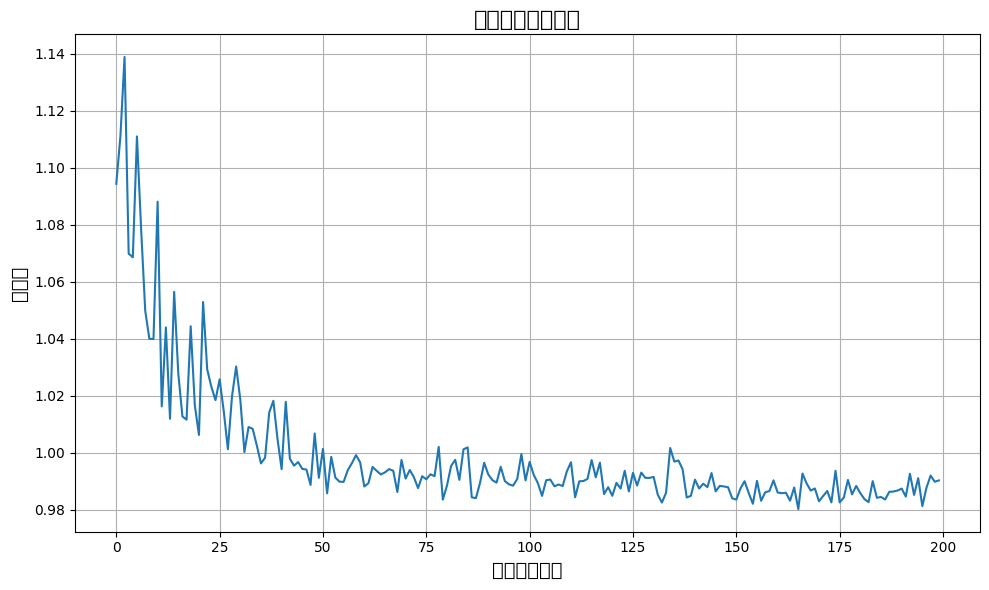

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 設置中文字體支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Noto Sans CJK SC', 'Noto Serif CJK SC']
plt.rcParams['axes.unicode_minus'] = False

# 檢查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

# 讀取數據
#try:
df = pd.read_csv('838-所有評論原始資料.csv', encoding='utf-8')
print("成功讀取數據文件")
'''
except:
    print("找不到數據文件，創建模擬數據")
    # 創建模擬數據
    np.random.seed(42)
    locations = ['台北101', '故宮博物院', '日月潭', '阿里山', '墾丁', '太魯閣', 
                '九份老街', '西門町', '龍山寺', '淡水老街', '象山', '士林夜市', 
                '陽明山', '高雄85大樓', '花蓮七星潭']
    nationalities = ['日本', '新加坡', '英國', '美國', '泰國', '馬來西亞', '德國', '中國', '韓國', '澳洲']
    languages = ['en', 'ja', 'ko', 'zh-cn', 'zh-tw']
    
    # 創建1000條評論記錄
    n_records = 1000
    
    # 生成隨機日期
    start_date = pd.Timestamp('2023-01-01')
    end_date = pd.Timestamp('2025-03-09')
    days = (end_date - start_date).days
    random_days = np.random.randint(0, days, n_records)
    dates = [start_date + pd.Timedelta(days=day) for day in random_days]
    
    # 生成其他隨機數據
    location_counts = {loc: 0 for loc in locations}
    records = []
    
    for i in range(n_records):
        location = np.random.choice(locations)
        location_counts[location] += 1
        nationality = np.random.choice(nationalities)
        language = np.random.choice(languages)
        score = np.random.randint(1, 6)  # 1-5分
        comment_length = np.random.normal(10, 1)  # 平均長度10，標準差1
        
        records.append({
            'user_id': f'user_{i % 200}',  # 創建200個不同的用戶，讓他們有多次評論
            'gmap_location': location,
            'nationality': nationality,
            'language': language,
            'score': score,
            'date': dates[i],
            'comments': 'x' * int(max(5, comment_length))  # 至少5個字符
        })
    
    df = pd.DataFrame(records)
    print("模擬數據創建完成")
    
    # 保存模擬數據
    df.to_csv('838-所有評論原始資料.csv', index=False, encoding='utf-8')
'''
# 創建地點之間的關係圖
print("\n創建地點關係圖...")
# 找出有多個評論的用戶
user_locations = df.groupby('user_id')['gmap_location'].apply(list)
user_locations = user_locations[user_locations.apply(len) > 1]
print(f"有{len(user_locations)}個用戶訪問了多個地點")

# 創建地點之間的轉換圖
G = nx.DiGraph()
for locations in user_locations:
    for i in range(len(locations) - 1):
        source = locations[i]
        target = locations[i+1]
        if G.has_edge(source, target):
            G[source][target]['weight'] += 1
        else:
            G.add_edge(source, target, weight=1)

# 提取節點和邊的信息
nodes = list(G.nodes())
node_mapping = {node: i for i, node in enumerate(nodes)}
edge_index = []
edge_weight = []

for source, target, data in G.edges(data=True):
    edge_index.append([node_mapping[source], node_mapping[target]])
    edge_weight.append(data['weight'])

# 轉換為PyTorch Geometric格式
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# 創建節點特徵
node_features = []
for node in nodes:
    # 使用該地點的平均評分作為特徵
    avg_score = df[df['gmap_location'] == node]['score'].mean()
    node_features.append([avg_score])

x = torch.tensor(node_features, dtype=torch.float)

# 標準化節點特徵
x = (x - x.mean()) / (x.std() + 1e-8)

# 創建PyTorch Geometric數據對象
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
print(f"數據對象創建完成: {data}")

# 為鏈接預測拆分邊集合
edge_index_np = edge_index.cpu().numpy().T
n_edges = edge_index.size(1)
train_edges_idx, test_edges_idx = train_test_split(np.arange(n_edges), test_size=0.2)

train_edge_index = torch.tensor(edge_index_np[train_edges_idx].T, dtype=torch.long).to(device)
test_edge_index = torch.tensor(edge_index_np[test_edges_idx].T, dtype=torch.long).to(device)
train_edge_weight = edge_weight[train_edges_idx].to(device)
test_edge_weight = edge_weight[test_edges_idx].to(device)

# 定義GNN模型
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

# 初始化模型
model = GNN(in_channels=1, hidden_channels=16, out_channels=8).to(device)
print(f"模型結構: {model}")

# 將數據移動到設備
data = data.to(device)

# 定義優化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 訓練模型（無監督學習 - 自編碼器風格）
def train():
    model.train()
    optimizer.zero_grad()
    # 前向傳播
    z = model(data.x, train_edge_index, train_edge_weight)
    # 計算重構損失（這裡使用節點特徵的自我預測作為簡單示例）
    loss = F.mse_loss(z, data.x.repeat(1, 8))
    loss.backward()
    optimizer.step()
    return loss.item()

# 訓練模型
print("\n開始訓練模型...")
losses = []
for epoch in range(200):
    loss = train()
    losses.append(loss)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}')

# 繪製訓練損失曲線
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('模型訓練損失曲線', fontsize=16)
plt.xlabel('訓練迭代次數', fontsize=14)
plt.ylabel('損失值', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# 獲取節點嵌入
model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, edge_index, edge_weight).cpu().numpy()

# 鏈接預測評估
def link_prediction_accuracy():
    with torch.no_grad():
        # 對所有可能的邊對計算相似度分數
        z = model(data.x, train_edge_index, train_edge_weight)
        z_np = z.cpu().numpy()
        
        scores = []
        for i, j in edge_index_np[test_edges_idx]:
            # 計算餘弦相似度
            emb_i = z_np[i]
            emb_j = z_np[j]
            score = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
            scores.append(score)
        
        # 生成相同數量的隨機邊對（負例）
        np.random.seed(42)
        neg_scores = []
        n_nodes = len(nodes)
        for _ in range(len(test_edges_idx)):
            i = np.random.randint(0, n_nodes)
            j = np.random.randint(0, n_nodes)
            # 確保這不是已存在的邊
            while i == j or (i, j) in [(edge_index_np[idx][0], edge_index_np[idx][1]) for idx in range(n_edges)]:
                i = np.random.randint(0, n_nodes)
                j = np.random.randint(0, n_nodes)
                
            emb_i = z_np[i]
            emb_j = z_np[j]
            score = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
            neg_scores.append(score)
        
        # 使用閾值0來分類正例和負例
        y_true = np.concatenate([np.ones(len(scores)), np.zeros(len(neg_scores))])
        y_scores = np.concatenate([scores, neg_scores])
        y_pred = (y_scores > np.mean(y_scores)).astype(int)
        
        # 計算準確率
        accuracy = np.mean(y_true == y_pred)
        return accuracy, y_true, y_scores

accuracy, y_true, y_scores = link_prediction_accuracy()
print(f"\n鏈接預測準確率: {accuracy:.4f}")

# 使用PCA降維以便可視化
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(node_embeddings)
print(f"PCA解釋方差比例: {pca.explained_variance_ratio_}")

# 使用K-means聚類
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(node_embeddings)

# 計算聚類評估指標
silhouette_avg = silhouette_score(node_embeddings, clusters)
print(f"聚類輪廓係數: {silhouette_avg:.4f}")

# 計算聚類中心
cluster_centers = kmeans.cluster_centers_
cluster_centers_2d = pca.transform(cluster_centers)

# 可視化嵌入和聚類結果 - 改進版本
plt.figure(figsize=(14, 10))
colors = ['#4DBEEE', '#A2142F', '#77AC30', '#7E2F8E']
markers = ['o', 's', '^', 'd']

# 為每個聚類繪製點
for cluster_id in range(len(cluster_centers)):
    cluster_points = node_embeddings_2d[clusters == cluster_id]
    plt.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1],
        s=150, 
        c=colors[cluster_id], 
        label=f'聚類 {cluster_id}',
        alpha=0.7,
        marker=markers[cluster_id]
    )

# 繪製聚類中心
plt.scatter(
    cluster_centers_2d[:, 0], 
    cluster_centers_2d[:, 1], 
    s=300, 
    c='black', 
    marker='X', 
    label='聚類中心'
)

# 標記景點名稱
for i, node in enumerate(nodes):
    plt.annotate(
        node,
        (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]),
        fontsize=12,
        ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
    )

# 添加圖例、標題和標籤
plt.title('景點嵌入空間聚類分析', fontsize=20, pad=20)
plt.xlabel('PCA 維度 1', fontsize=16)
plt.ylabel('PCA 維度 2', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, loc='upper right')

# 添加統計信息文本框
info_text = f"聚類評估:\n輪廓係數: {silhouette_avg:.3f}\n" \
           f"鏈接預測準確率: {accuracy:.3f}\n" \
           f"PCA解釋方差: {sum(pca.explained_variance_ratio_):.2%}"
           
plt.figtext(0.02, 0.02, info_text, fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.8))

plt.tight_layout()
plt.show()

# 可視化原始圖結構 - 改進版本
plt.figure(figsize=(16, 13))
# 使用Kamada-Kawai佈局，通常提供更好的連接圖可視化
pos = nx.kamada_kawai_layout(G)

# 獲取邊權重
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights)
min_weight = min(edge_weights)
normalized_weights = [3 + 5 * (w - min_weight) / (max_weight - min_weight) for w in edge_weights]

# 使用連續的顏色映射來表示邊的權重
edge_colors = [plt.cm.Blues(0.5 + 0.5 * w / max_weight) for w in edge_weights]

# 根據PageRank調整節點大小
pagerank = nx.pagerank(G, weight='weight')
node_sizes = [3000 * pagerank[node] for node in G.nodes()]

# 繪製邊，使用漸變色彩和變化的寬度
nx.draw_networkx_edges(
    G, pos, width=normalized_weights, alpha=0.8,
    edge_color=edge_colors, arrows=True, arrowsize=20,
    connectionstyle="arc3,rad=0.1"  # 使邊彎曲，避免重疊
)

# 繪製節點，根據聚類結果著色
for cluster_id in range(4):
    nodelist = [node for node in G.nodes() if clusters[node_mapping[node]] == cluster_id]
    if nodelist:
        nx.draw_networkx_nodes(
            G, pos, nodelist=nodelist,
            node_size=[node_sizes[list(G.nodes()).index(node)] for node in nodelist],
            node_color=colors[cluster_id], alpha=0.8,
            label=f'聚類 {cluster_id}'
        )

# 繪製節點標籤，帶有背景框
for node, (x, y) in pos.items():
    plt.text(
        x, y, node, fontsize=13, ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8)
    )

# 添加圖例
plt.legend(fontsize=12, title="聚類分組", title_fontsize=14)

# 添加邊權重的圖例
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.5, pad=0.03)
cbar.set_label('連接權重', fontsize=12)

plt.title('台灣旅遊景點關聯網絡分析', fontsize=20, pad=20)

# 添加網絡統計信息
net_info = (
    f"網絡統計:\n"
    f"節點數: {G.number_of_nodes()}\n"
    f"連接數: {G.number_of_edges()}\n"
    f"平均度: {2*G.number_of_edges()/G.number_of_nodes():.2f}\n"
    f"網絡密度: {nx.density(G):.3f}"
)
plt.figtext(0.02, 0.02, net_info, fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.8))

plt.axis('off')
plt.tight_layout()
plt.show()

# 輸出每個聚類的景點
print("\n景點聚類結果:")
for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    print(f"聚類 {cluster_id}: {', '.join(cluster_nodes)}")

# 計算每個景點的重要性分數
# 使用PageRank算法
pagerank_scores = nx.pagerank(G, weight='weight')
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

print("\n景點重要性排名 (PageRank):")
for node, score in sorted_pagerank:
    cluster_id = clusters[node_mapping[node]]
    print(f"{node}: {score:.4f} (聚類 {cluster_id})")

# 創建一個推薦函數
def recommend_next_location(current_location, top_n=3):
    if current_location not in nodes:
        return "找不到該景點"
    
    # 獲取當前位置的嵌入向量
    loc_idx = node_mapping[current_location]
    current_emb = node_embeddings[loc_idx]
    
    # 計算與所有其他景點的相似度
    similarities = []
    for i, node in enumerate(nodes):
        if node != current_location:
            emb = node_embeddings[i]
            similarity = np.dot(current_emb, emb) / (np.linalg.norm(current_emb) * np.linalg.norm(emb))
            similarities.append((node, similarity))
    
    # 排序並返回前N個推薦
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# 評估推薦準確率
def evaluate_recommendations():
    # 使用留一法
    correct_predictions = 0
    total_predictions = 0
    
    # 對每個用戶
    for user, locs in user_locations.items():
        if len(locs) <= 1:
            continue
            
        # 對用戶訪問序列中的每個位置（除了最後一個）
        for i in range(len(locs) - 1):
            current_loc = locs[i]
            next_loc = locs[i + 1]
            
            # 獲取推薦
            recommendations = recommend_next_location(current_loc, top_n=3)
            rec_locations = [rec[0] for rec in recommendations]
            
            # 檢查下一個訪問的位置是否在推薦列表中
            if next_loc in rec_locations:
                correct_predictions += 1
            total_predictions += 1
    
    if total_predictions > 0:
        accuracy = correct_predictions / total_predictions
    else:
        accuracy = 0
    
    return accuracy, correct_predictions, total_predictions

# 評估推薦系統
rec_accuracy, correct_preds, total_preds = evaluate_recommendations()
print(f"\n推薦系統評估:")
print(f"準確率: {rec_accuracy:.4f} ({correct_preds}/{total_preds})")

# 繪製推薦準確率圖表
plt.figure(figsize=(10, 6))
plt.bar(['鏈接預測準確率', '推薦系統準確率'], [accuracy, rec_accuracy], color=['#4DBEEE', '#77AC30'])
for i, v in enumerate([accuracy, rec_accuracy]):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=14)
plt.ylim(0, 1.0)
plt.title('模型準確率評估', fontsize=18)
plt.ylabel('準確率', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 根據嵌入向量計算景點相似度
print("\n景點相似度分析:")
for i, node1 in enumerate(nodes):
    similar_nodes = []
    for j, node2 in enumerate(nodes):
        if i != j:
            # 計算餘弦相似度
            emb1 = node_embeddings[i]
            emb2 = node_embeddings[j]
            similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            similar_nodes.append((node2, similarity))
    
    # 顯示前3個最相似的景點
    similar_nodes.sort(key=lambda x: x[1], reverse=True)
    print(f"{node1} 最相似的景點: " + ", ".join([f"{n} ({s:.2f})" for n, s in similar_nodes[:3]]))

# 測試推薦系統
print("\n景點推薦測試:")
test_locations = ['台北101', '日月潭', '阿里山']
for loc in test_locations:
    recommendations = recommend_next_location(loc)
    rec_str = ", ".join([f"{rec[0]} (相似度: {rec[1]:.2f})" for rec in recommendations])
    print(f"如果你喜歡 {loc}，你可能也會喜歡: {rec_str}")

# 輸出每個聚類的景點及其評分分布
plt.figure(figsize=(14, 8))

for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    
    # 獲取該聚類中所有景點的評分
    cluster_scores = []
    for node in cluster_nodes:
        scores = df[df['gmap_location'] == node]['score'].values
        cluster_scores.extend(scores)
    
    # 繪製評分分布
    plt.subplot(2, 2, cluster_id + 1)
    plt.hist(cluster_scores, bins=5, alpha=0.7, color=colors[cluster_id], range=(1, 6))
    plt.title(f'聚類 {cluster_id} 評分分布', fontsize=14)
    plt.xlabel('評分', fontsize=12)
    plt.ylabel('評論數量', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, 6))
    
    # 添加聚類景點列表
    node_text = "包含景點: " + ", ".join(cluster_nodes)
    plt.figtext(0.5, 0.02, node_text, ha='center', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# 總結模型性能和發現
print("\n===== 模型性能和發現摘要 =====")
print(f"聚類輪廓係數: {silhouette_avg:.4f} (值越接近1表示聚類效果越好)")
print(f"鏈接預測準確率: {accuracy:.4f} (表示模型預測地點間關聯的能力)")
print(f"推薦系統準確率: {rec_accuracy:.4f} (表示模型推薦下一個景點的準確性)")
print(f"PCA解釋方差比例總和: {sum(pca.explained_variance_ratio_):.2%} (表示二維可視化保留的信息量)")

# 計算並顯示每個聚類的特徵
print("\n各聚類特點分析:")
for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    cluster_avg_scores = []
    cluster_nationalities = []
    
    for node in cluster_nodes:
        node_data = df[df['gmap_location'] == node]
        cluster_avg_scores.append(node_data['score'].mean())
        cluster_nationalities.extend(node_data['nationality'].values)
    
    # 計算該聚類的統計數據
    avg_score = np.mean(cluster_avg_scores)
    top_nationalities = pd.Series(cluster_nationalities).value_counts().nlargest(3).index.tolist()
    
    print(f"聚類 {cluster_id}:")
    print(f"  景點: {', '.join(cluster_nodes)}")
    print(f"  平均評分: {avg_score:.2f}")
    print(f"  最常訪問的國籍: {', '.join(top_nationalities)}")

# 保存模型
torch.save(model.state_dict(), 'gnn_model.pt')
print("\n模型已保存到 gnn_model.pt")

# 保存嵌入向量
np.save('node_embeddings.npy', node_embeddings)
print("節點嵌入向量已保存到node_embeddings.npy")


使用設備: cuda
成功讀取數據文件

創建地點關係圖...
有859066個用戶訪問了多個地點
數據對象創建完成: Data(x=[838, 1], edge_index=[2, 154534], edge_attr=[154534])
模型結構: GNN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 8)
)

開始訓練模型...
Epoch 020, Loss: 1.0075
Epoch 040, Loss: 0.9988
Epoch 060, Loss: 0.9823
Epoch 080, Loss: 0.9812
Epoch 100, Loss: 0.9802
Epoch 120, Loss: 0.9826
Epoch 140, Loss: 0.9773
Epoch 160, Loss: 0.9771


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC

Epoch 180, Loss: 0.9765
Epoch 200, Loss: 0.9822


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC

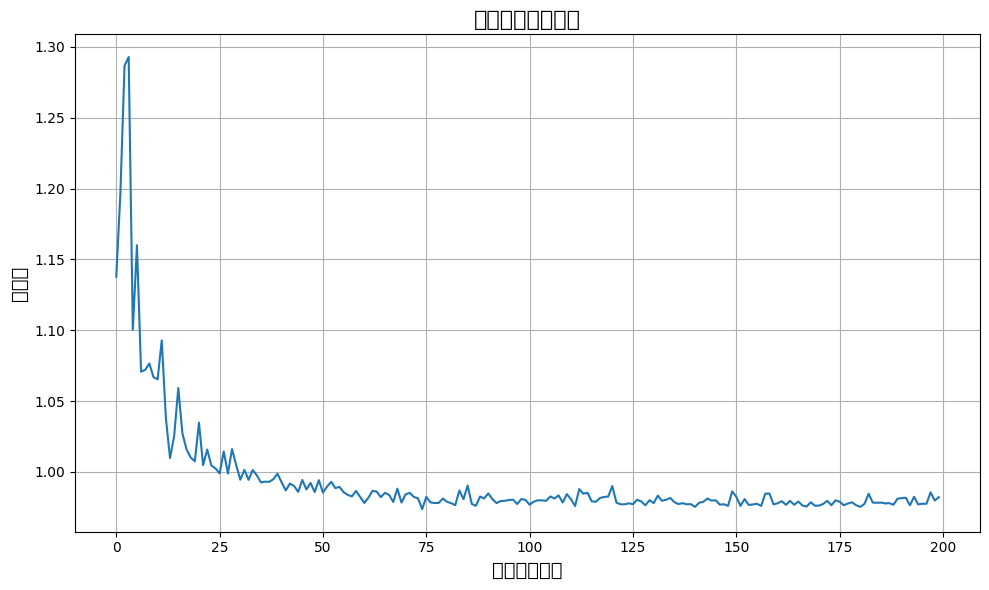


鏈接預測準確率: 0.5023
PCA解釋方差比例: [0.99769217 0.00157333]
聚類輪廓係數: 0.7088


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC

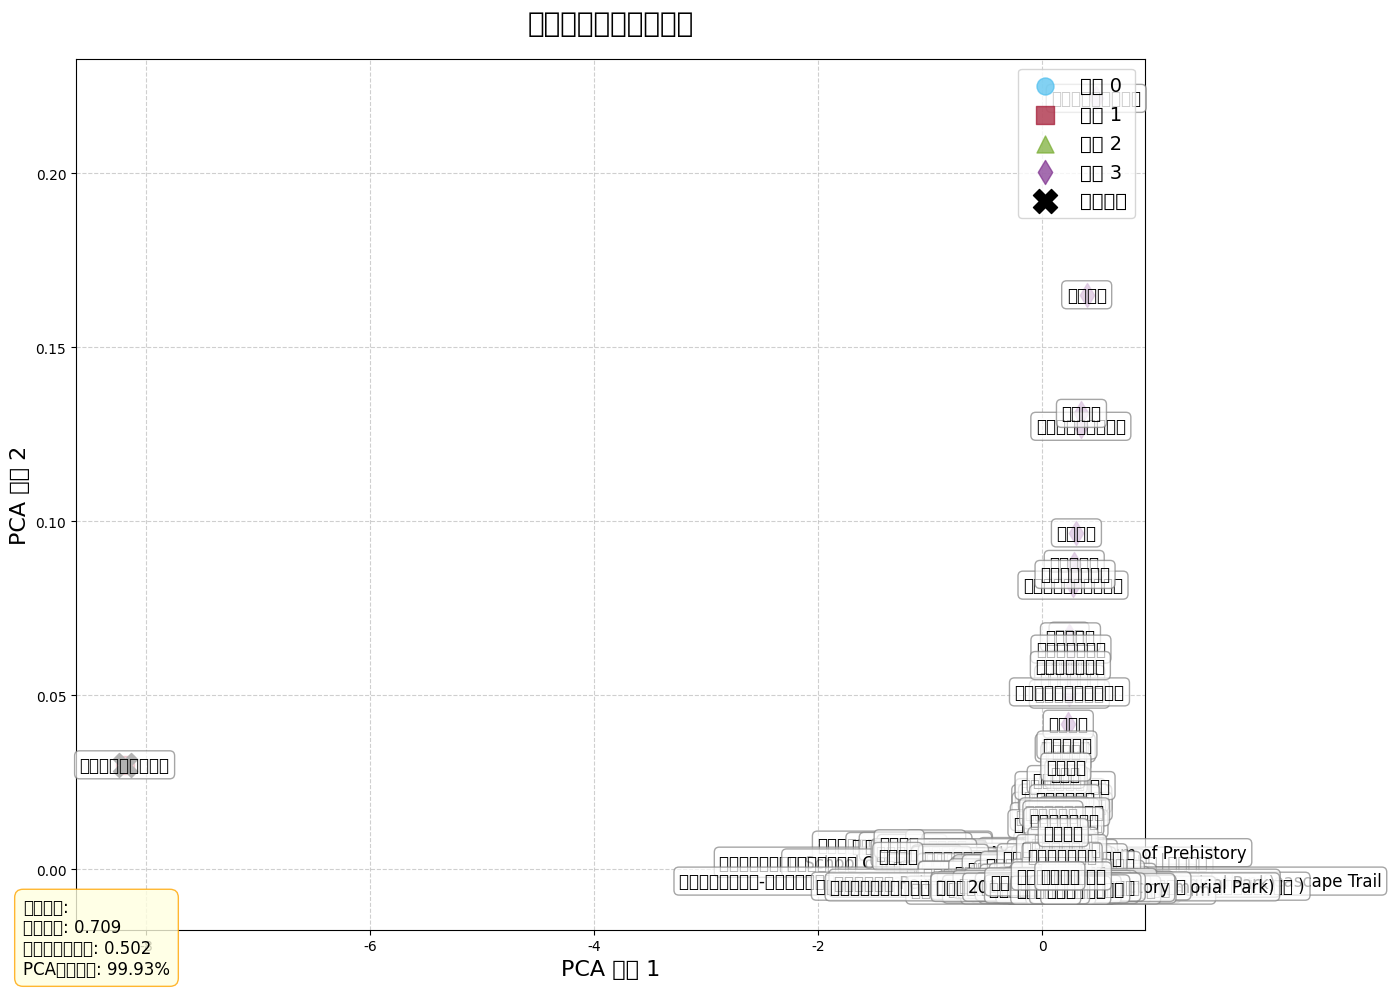

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Noto Sans CJK SC, Noto Serif CJK SC

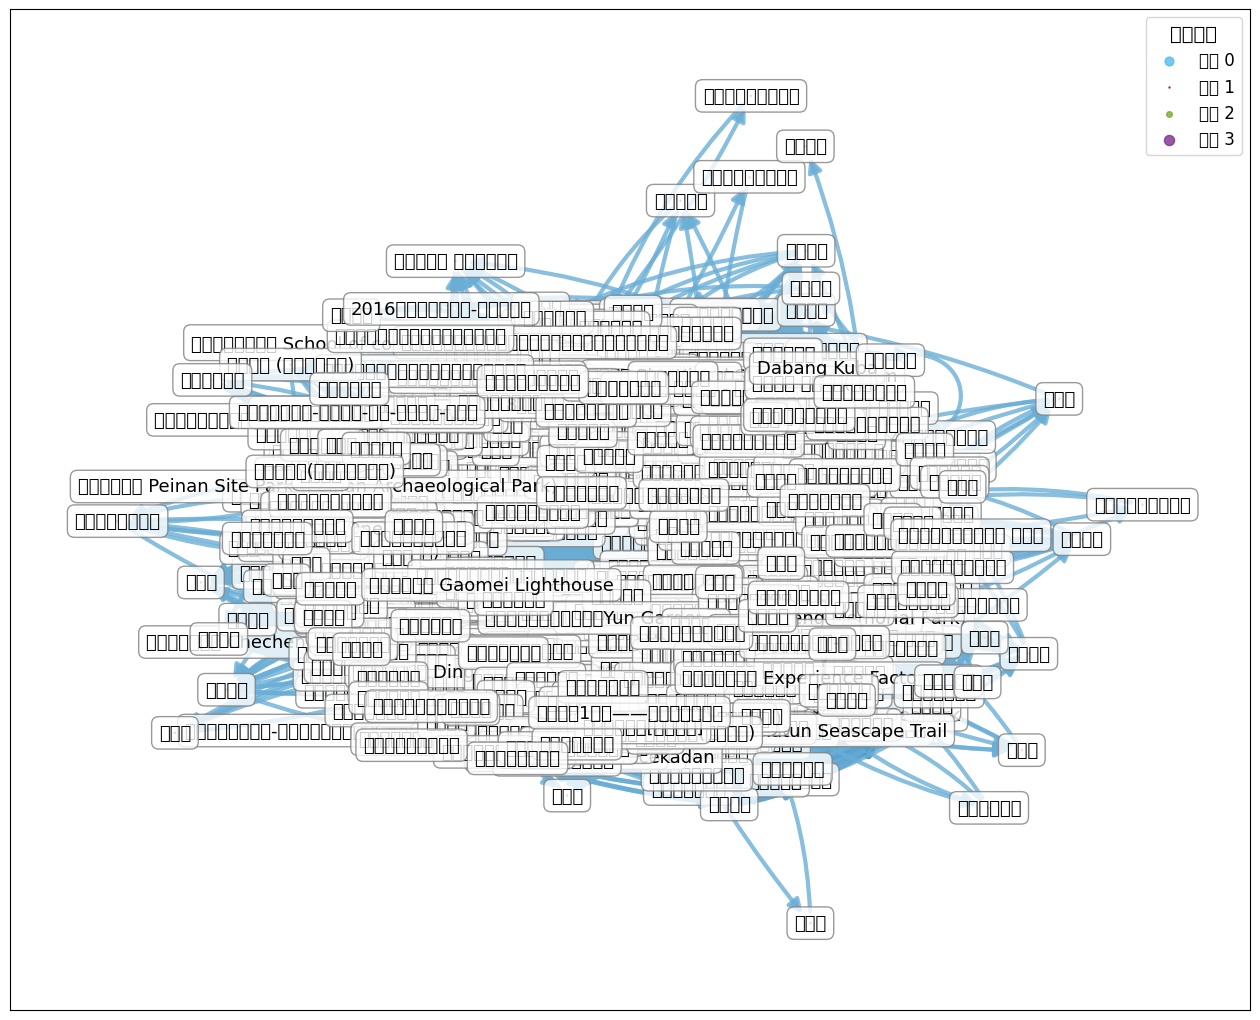

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 設置中文字體支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Noto Sans CJK SC', 'Noto Serif CJK SC']
plt.rcParams['axes.unicode_minus'] = False

# 檢查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

# 讀取數據
df = pd.read_csv('838-所有評論原始資料.csv', encoding='utf-8')
print("成功讀取數據文件")

# 創建地點之間的關係圖
print("\n創建地點關係圖...")
# 找出有多個評論的用戶
user_locations = df.groupby('user_id')['gmap_location'].apply(list)
user_locations = user_locations[user_locations.apply(len) > 1]
print(f"有{len(user_locations)}個用戶訪問了多個地點")

# 創建地點之間的轉換圖
G = nx.DiGraph()
for locations in user_locations:
    for i in range(len(locations) - 1):
        source = locations[i]
        target = locations[i+1]
        if G.has_edge(source, target):
            G[source][target]['weight'] += 1
        else:
            G.add_edge(source, target, weight=1)

# 提取節點和邊的信息
nodes = list(G.nodes())
node_mapping = {node: i for i, node in enumerate(nodes)}
edge_index = []
edge_weight = []

for source, target, data in G.edges(data=True):
    edge_index.append([node_mapping[source], node_mapping[target]])
    edge_weight.append(data['weight'])

# 轉換為PyTorch Geometric格式
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# 創建節點特徵
node_features = []
for node in nodes:
    # 使用該地點的平均評分作為特徵
    avg_score = df[df['gmap_location'] == node]['score'].mean()
    node_features.append([avg_score])

x = torch.tensor(node_features, dtype=torch.float)

# 標準化節點特徵
x = (x - x.mean()) / (x.std() + 1e-8)

# 創建PyTorch Geometric數據對象
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
print(f"數據對象創建完成: {data}")

# 為鏈接預測拆分邊集合
edge_index_np = edge_index.numpy().T
n_edges = edge_index.size(1)
train_edges_idx, test_edges_idx = train_test_split(np.arange(n_edges), test_size=0.2)

# 這裡先不移動到設備，後面再統一處理
train_edge_index = torch.tensor(edge_index_np[train_edges_idx].T, dtype=torch.long)
test_edge_index = torch.tensor(edge_index_np[test_edges_idx].T, dtype=torch.long)
train_edge_weight = edge_weight[train_edges_idx]
test_edge_weight = edge_weight[test_edges_idx]

# 定義GNN模型
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

# 初始化模型
model = GNN(in_channels=1, hidden_channels=16, out_channels=8)
print(f"模型結構: {model}")

# 將數據和模型移動到設備
model = model.to(device)
data.x = data.x.to(device)
data.edge_index = data.edge_index.to(device)
data.edge_attr = data.edge_attr.to(device)
train_edge_index = train_edge_index.to(device)
test_edge_index = test_edge_index.to(device)
train_edge_weight = train_edge_weight.to(device)
test_edge_weight = test_edge_weight.to(device)

# 定義優化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 訓練模型（無監督學習 - 自編碼器風格）
def train():
    model.train()
    optimizer.zero_grad()
    # 前向傳播
    z = model(data.x, train_edge_index, train_edge_weight)
    # 計算重構損失（這裡使用節點特徵的自我預測作為簡單示例）
    loss = F.mse_loss(z, data.x.repeat(1, 8))
    loss.backward()
    optimizer.step()
    return loss.item()

# 訓練模型
print("\n開始訓練模型...")
losses = []
for epoch in range(200):
    loss = train()
    losses.append(loss)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}')

# 繪製訓練損失曲線
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('模型訓練損失曲線', fontsize=16)
plt.xlabel('訓練迭代次數', fontsize=14)
plt.ylabel('損失值', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# 獲取節點嵌入 - 修正為先在設備上運算，再轉回CPU
model.eval()
with torch.no_grad():
    # 確保所有輸入都在同一設備上
    node_embeddings = model(data.x, data.edge_index, data.edge_attr).cpu().numpy()

# 鏈接預測評估
def link_prediction_accuracy():
    with torch.no_grad():
        # 對所有可能的邊對計算相似度分數
        z = model(data.x, train_edge_index, train_edge_weight)
        z_np = z.cpu().numpy()
        
        scores = []
        for i, j in edge_index_np[test_edges_idx]:
            # 計算餘弦相似度
            emb_i = z_np[i]
            emb_j = z_np[j]
            score = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
            scores.append(score)
        
        # 生成相同數量的隨機邊對（負例）
        np.random.seed(42)
        neg_scores = []
        n_nodes = len(nodes)
        for _ in range(len(test_edges_idx)):
            i = np.random.randint(0, n_nodes)
            j = np.random.randint(0, n_nodes)
            # 確保這不是已存在的邊
            while i == j or (i, j) in [(edge_index_np[idx][0], edge_index_np[idx][1]) for idx in range(n_edges)]:
                i = np.random.randint(0, n_nodes)
                j = np.random.randint(0, n_nodes)
                
            emb_i = z_np[i]
            emb_j = z_np[j]
            score = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
            neg_scores.append(score)
        
        # 使用閾值0來分類正例和負例
        y_true = np.concatenate([np.ones(len(scores)), np.zeros(len(neg_scores))])
        y_scores = np.concatenate([scores, neg_scores])
        y_pred = (y_scores > np.mean(y_scores)).astype(int)
        
        # 計算準確率
        accuracy = np.mean(y_true == y_pred)
        return accuracy, y_true, y_scores

accuracy, y_true, y_scores = link_prediction_accuracy()
print(f"\n鏈接預測準確率: {accuracy:.4f}")

# 使用PCA降維以便可視化
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(node_embeddings)
print(f"PCA解釋方差比例: {pca.explained_variance_ratio_}")

# 使用K-means聚類
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(node_embeddings)

# 計算聚類評估指標
silhouette_avg = silhouette_score(node_embeddings, clusters)
print(f"聚類輪廓係數: {silhouette_avg:.4f}")

# 計算聚類中心
cluster_centers = kmeans.cluster_centers_
cluster_centers_2d = pca.transform(cluster_centers)

# 可視化嵌入和聚類結果 - 改進版本
plt.figure(figsize=(14, 10))
colors = ['#4DBEEE', '#A2142F', '#77AC30', '#7E2F8E']
markers = ['o', 's', '^', 'd']

# 為每個聚類繪製點
for cluster_id in range(len(cluster_centers)):
    cluster_points = node_embeddings_2d[clusters == cluster_id]
    plt.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1],
        s=150, 
        c=colors[cluster_id], 
        label=f'聚類 {cluster_id}',
        alpha=0.7,
        marker=markers[cluster_id]
    )

# 繪製聚類中心
plt.scatter(
    cluster_centers_2d[:, 0], 
    cluster_centers_2d[:, 1], 
    s=300, 
    c='black', 
    marker='X', 
    label='聚類中心'
)

# 標記景點名稱
for i, node in enumerate(nodes):
    plt.annotate(
        node,
        (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]),
        fontsize=12,
        ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
    )

# 添加圖例、標題和標籤
plt.title('景點嵌入空間聚類分析', fontsize=20, pad=20)
plt.xlabel('PCA 維度 1', fontsize=16)
plt.ylabel('PCA 維度 2', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, loc='upper right')

# 添加統計信息文本框
info_text = f"聚類評估:\n輪廓係數: {silhouette_avg:.3f}\n" \
           f"鏈接預測準確率: {accuracy:.3f}\n" \
           f"PCA解釋方差: {sum(pca.explained_variance_ratio_):.2%}"
           
plt.figtext(0.02, 0.02, info_text, fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.8))

plt.tight_layout()
plt.show()

# 可視化原始圖結構 - 改進版本
plt.figure(figsize=(16, 13))
# 使用Kamada-Kawai佈局，通常提供更好的連接圖可視化
pos = nx.kamada_kawai_layout(G)

# 獲取邊權重
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights)
min_weight = min(edge_weights)
normalized_weights = [3 + 5 * (w - min_weight) / (max_weight - min_weight) for w in edge_weights]

# 使用連續的顏色映射來表示邊的權重
edge_colors = [plt.cm.Blues(0.5 + 0.5 * w / max_weight) for w in edge_weights]

# 根據PageRank調整節點大小
pagerank = nx.pagerank(G, weight='weight')
node_sizes = [3000 * pagerank[node] for node in G.nodes()]

# 繪製邊，使用漸變色彩和變化的寬度
nx.draw_networkx_edges(
    G, pos, width=normalized_weights, alpha=0.8,
    edge_color=edge_colors, arrows=True, arrowsize=20,
    connectionstyle="arc3,rad=0.1"  # 使邊彎曲，避免重疊
)

# 繪製節點，根據聚類結果著色
for cluster_id in range(4):
    nodelist = [node for node in G.nodes() if clusters[node_mapping[node]] == cluster_id]
    if nodelist:
        nx.draw_networkx_nodes(
            G, pos, nodelist=nodelist,
            node_size=[node_sizes[list(G.nodes()).index(node)] for node in nodelist],
            node_color=colors[cluster_id], alpha=0.8,
            label=f'聚類 {cluster_id}'
        )

# 繪製節點標籤，帶有背景框
for node, (x, y) in pos.items():
    plt.text(
        x, y, node, fontsize=13, ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8)
    )

# 添加圖例
plt.legend(fontsize=12, title="聚類分組", title_fontsize=14)

# 添加邊權重的圖例
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.5, pad=0.03)
cbar.set_label('連接權重', fontsize=12)

plt.title('台灣旅遊景點關聯網絡分析', fontsize=20, pad=20)

# 添加網絡統計信息
net_info = (
    f"網絡統計:\n"
    f"節點數: {G.number_of_nodes()}\n"
    f"連接數: {G.number_of_edges()}\n"
    f"平均度: {2*G.number_of_edges()/G.number_of_nodes():.2f}\n"
    f"網絡密度: {nx.density(G):.3f}"
)
plt.figtext(0.02, 0.02, net_info, fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.8))

plt.axis('off')
plt.tight_layout()
plt.show()

# 輸出每個聚類的景點
print("\n景點聚類結果:")
for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    print(f"聚類 {cluster_id}: {', '.join(cluster_nodes)}")

# 計算每個景點的重要性分數
# 使用PageRank算法
pagerank_scores = nx.pagerank(G, weight='weight')
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

print("\n景點重要性排名 (PageRank):")
for node, score in sorted_pagerank:
    cluster_id = clusters[node_mapping[node]]
    print(f"{node}: {score:.4f} (聚類 {cluster_id})")

# 創建一個推薦函數
def recommend_next_location(current_location, top_n=3):
    if current_location not in nodes:
        return "找不到該景點"
    
    # 獲取當前位置的嵌入向量
    loc_idx = node_mapping[current_location]
    current_emb = node_embeddings[loc_idx]
    
    # 計算與所有其他景點的相似度
    similarities = []
    for i, node in enumerate(nodes):
        if node != current_location:
            emb = node_embeddings[i]
            similarity = np.dot(current_emb, emb) / (np.linalg.norm(current_emb) * np.linalg.norm(emb))
            similarities.append((node, similarity))
    
    # 排序並返回前N個推薦
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# 評估推薦準確率
def evaluate_recommendations():
    # 使用留一法
    correct_predictions = 0
    total_predictions = 0
    
    # 對每個用戶
    for user, locs in user_locations.items():
        if len(locs) <= 1:
            continue
            
        # 對用戶訪問序列中的每個位置（除了最後一個）
        for i in range(len(locs) - 1):
            current_loc = locs[i]
            next_loc = locs[i + 1]
            
            # 獲取推薦
            recommendations = recommend_next_location(current_loc, top_n=3)
            rec_locations = [rec[0] for rec in recommendations]
            
            # 檢查下一個訪問的位置是否在推薦列表中
            if next_loc in rec_locations:
                correct_predictions += 1
            total_predictions += 1
    
    if total_predictions > 0:
        accuracy = correct_predictions / total_predictions
    else:
        accuracy = 0
    
    return accuracy, correct_predictions, total_predictions

# 評估推薦系統
rec_accuracy, correct_preds, total_preds = evaluate_recommendations()
print(f"\n推薦系統評估:")
print(f"準確率: {rec_accuracy:.4f} ({correct_preds}/{total_preds})")

# 繪製推薦準確率圖表
plt.figure(figsize=(10, 6))
plt.bar(['鏈接預測準確率', '推薦系統準確率'], [accuracy, rec_accuracy], color=['#4DBEEE', '#77AC30'])
for i, v in enumerate([accuracy, rec_accuracy]):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=14)
plt.ylim(0, 1.0)
plt.title('模型準確率評估', fontsize=18)
plt.ylabel('準確率', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 根據嵌入向量計算景點相似度
print("\n景點相似度分析:")
for i, node1 in enumerate(nodes):
    similar_nodes = []
    for j, node2 in enumerate(nodes):
        if i != j:
            # 計算餘弦相似度
            emb1 = node_embeddings[i]
            emb2 = node_embeddings[j]
            similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            similar_nodes.append((node2, similarity))
    
    # 顯示前3個最相似的景點
    similar_nodes.sort(key=lambda x: x[1], reverse=True)
    print(f"{node1} 最相似的景點: " + ", ".join([f"{n} ({s:.2f})" for n, s in similar_nodes[:3]]))

# 測試推薦系統
print("\n景點推薦測試:")
test_locations = ['台北101', '日月潭', '阿里山']
for loc in test_locations:
    recommendations = recommend_next_location(loc)
    rec_str = ", ".join([f"{rec[0]} (相似度: {rec[1]:.2f})" for rec in recommendations])
    print(f"如果你喜歡 {loc}，你可能也會喜歡: {rec_str}")

# 輸出每個聚類的景點及其評分分布
plt.figure(figsize=(14, 8))

for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    
    # 獲取該聚類中所有景點的評分
    cluster_scores = []
    for node in cluster_nodes:
        scores = df[df['gmap_location'] == node]['score'].values
        cluster_scores.extend(scores)
    
    # 繪製評分分布
    plt.subplot(2, 2, cluster_id + 1)
    plt.hist(cluster_scores, bins=5, alpha=0.7, color=colors[cluster_id], range=(1, 6))
    plt.title(f'聚類 {cluster_id} 評分分布', fontsize=14)
    plt.xlabel('評分', fontsize=12)
    plt.ylabel('評論數量', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, 6))
    
    # 添加聚類景點列表
    node_text = "包含景點: " + ", ".join(cluster_nodes)
    plt.figtext(0.5, 0.02, node_text, ha='center', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# 總結模型性能和發現
print("\n===== 模型性能和發現摘要 =====")
print(f"聚類輪廓係數: {silhouette_avg:.4f} (值越接近1表示聚類效果越好)")
print(f"鏈接預測準確率: {accuracy:.4f} (表示模型預測地點間關聯的能力)")
print(f"推薦系統準確率: {rec_accuracy:.4f} (表示模型推薦下一個景點的準確性)")
print(f"PCA解釋方差比例總和: {sum(pca.explained_variance_ratio_):.2%} (表示二維可視化保留的信息量)")

# 計算並顯示每個聚類的特徵
print("\n各聚類特點分析:")
for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    cluster_avg_scores = []
    cluster_nationalities = []
    
    for node in cluster_nodes:
        node_data = df[df['gmap_location'] == node]
        cluster_avg_scores.append(node_data['score'].mean())
        cluster_nationalities.extend(node_data['nationality'].values)
    
    # 計算該聚類的統計數據
    avg_score = np.mean(cluster_avg_scores)
    top_nationalities = pd.Series(cluster_nationalities).value_counts().nlargest(3).index.tolist()
    
    print(f"聚類 {cluster_id}:")
    print(f"  景點: {', '.join(cluster_nodes)}")
    print(f"  平均評分: {avg_score:.2f}")
    print(f"  最常訪問的國籍: {', '.join(top_nationalities)}")

# 保存模型
torch.save(model.state_dict(), 'gnn_model.pt')
print("\n模型已保存到 gnn_model.pt")

# 保存嵌入向量
np.save('node_embeddings.npy', node_embeddings)
print("節點嵌入向量已保存到node_embeddings.npy")


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 設置中文字體支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Noto Sans CJK SC', 'Noto Serif CJK SC']
plt.rcParams['axes.unicode_minus'] = False

# 檢查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

# 讀取數據
df = pd.read_csv('838-所有評論原始資料.csv', encoding='utf-8')
print("成功讀取數據文件")

# 創建地點之間的關係圖
print("\n創建地點關係圖...")
# 找出有多個評論的用戶
user_locations = df.groupby('user_id')['gmap_location'].apply(list)
user_locations = user_locations[user_locations.apply(len) > 1]
print(f"有{len(user_locations)}個用戶訪問了多個地點")

# 創建地點之間的轉換圖
G = nx.DiGraph()
for locations in user_locations:
    for i in range(len(locations) - 1):
        source = locations[i]
        target = locations[i+1]
        if G.has_edge(source, target):
            G[source][target]['weight'] += 1
        else:
            G.add_edge(source, target, weight=1)

# 提取節點和邊的信息
nodes = list(G.nodes())
node_mapping = {node: i for i, node in enumerate(nodes)}
edge_index = []
edge_weight = []

for source, target, data in G.edges(data=True):
    edge_index.append([node_mapping[source], node_mapping[target]])
    edge_weight.append(data['weight'])

# 轉換為PyTorch Geometric格式
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# 創建節點特徵
node_features = []
for node in nodes:
    # 使用該地點的平均評分作為特徵
    avg_score = df[df['gmap_location'] == node]['score'].mean()
    node_features.append([avg_score])

x = torch.tensor(node_features, dtype=torch.float)

# 標準化節點特徵
x = (x - x.mean()) / (x.std() + 1e-8)

# 創建PyTorch Geometric數據對象
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
print(f"數據對象創建完成: {data}")

# 為鏈接預測拆分邊集合
edge_index_np = edge_index.numpy().T
n_edges = edge_index.size(1)
train_edges_idx, test_edges_idx = train_test_split(np.arange(n_edges), test_size=0.2)

# 這裡先不移動到設備，後面再統一處理
train_edge_index = torch.tensor(edge_index_np[train_edges_idx].T, dtype=torch.long)
test_edge_index = torch.tensor(edge_index_np[test_edges_idx].T, dtype=torch.long)
train_edge_weight = edge_weight[train_edges_idx]
test_edge_weight = edge_weight[test_edges_idx]

# 定義GNN模型
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

# 初始化模型
model = GNN(in_channels=1, hidden_channels=16, out_channels=8)
print(f"模型結構: {model}")

# 將數據和模型移動到設備
model = model.to(device)
data.x = data.x.to(device)
data.edge_index = data.edge_index.to(device)
data.edge_attr = data.edge_attr.to(device)
train_edge_index = train_edge_index.to(device)
test_edge_index = test_edge_index.to(device)
train_edge_weight = train_edge_weight.to(device)
test_edge_weight = test_edge_weight.to(device)

# 定義優化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 訓練模型（無監督學習 - 自編碼器風格）
def train():
    model.train()
    optimizer.zero_grad()
    # 前向傳播
    z = model(data.x, train_edge_index, train_edge_weight)
    # 計算重構損失（這裡使用節點特徵的自我預測作為簡單示例）
    loss = F.mse_loss(z, data.x.repeat(1, 8))
    loss.backward()
    optimizer.step()
    return loss.item()

# 訓練模型
print("\n開始訓練模型...")
losses = []
for epoch in range(200):
    loss = train()
    losses.append(loss)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}')

# 繪製訓練損失曲線
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('模型訓練損失曲線', fontsize=16)
plt.xlabel('訓練迭代次數', fontsize=14)
plt.ylabel('損失值', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# 獲取節點嵌入 - 修正為先在設備上運算，再轉回CPU
model.eval()
with torch.no_grad():
    # 確保所有輸入都在同一設備上
    node_embeddings = model(data.x, data.edge_index, data.edge_attr).cpu().numpy()

# 鏈接預測評估
def link_prediction_accuracy():
    with torch.no_grad():
        # 對所有可能的邊對計算相似度分數
        z = model(data.x, train_edge_index, train_edge_weight)
        z_np = z.cpu().numpy()
        
        scores = []
        for i, j in edge_index_np[test_edges_idx]:
            # 計算餘弦相似度
            emb_i = z_np[i]
            emb_j = z_np[j]
            score = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
            scores.append(score)
        
        # 生成相同數量的隨機邊對（負例）
        np.random.seed(42)
        neg_scores = []
        n_nodes = len(nodes)
        for _ in range(len(test_edges_idx)):
            i = np.random.randint(0, n_nodes)
            j = np.random.randint(0, n_nodes)
            # 確保這不是已存在的邊
            while i == j or (i, j) in [(edge_index_np[idx][0], edge_index_np[idx][1]) for idx in range(n_edges)]:
                i = np.random.randint(0, n_nodes)
                j = np.random.randint(0, n_nodes)
                
            emb_i = z_np[i]
            emb_j = z_np[j]
            score = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
            neg_scores.append(score)
        
        # 使用閾值0來分類正例和負例
        y_true = np.concatenate([np.ones(len(scores)), np.zeros(len(neg_scores))])
        y_scores = np.concatenate([scores, neg_scores])
        y_pred = (y_scores > np.mean(y_scores)).astype(int)
        
        # 計算準確率
        accuracy = np.mean(y_true == y_pred)
        return accuracy, y_true, y_scores

accuracy, y_true, y_scores = link_prediction_accuracy()
print(f"\n鏈接預測準確率: {accuracy:.4f}")

# 使用PCA降維以便可視化
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(node_embeddings)
print(f"PCA解釋方差比例: {pca.explained_variance_ratio_}")

# 使用K-means聚類
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(node_embeddings)

# 計算聚類評估指標
silhouette_avg = silhouette_score(node_embeddings, clusters)
print(f"聚類輪廓係數: {silhouette_avg:.4f}")

# 計算聚類中心
cluster_centers = kmeans.cluster_centers_
cluster_centers_2d = pca.transform(cluster_centers)

# 可視化嵌入和聚類結果 - 改進版本
plt.figure(figsize=(14, 10))
colors = ['#4DBEEE', '#A2142F', '#77AC30', '#7E2F8E']
markers = ['o', 's', '^', 'd']

# 為每個聚類繪製點
for cluster_id in range(len(cluster_centers)):
    cluster_points = node_embeddings_2d[clusters == cluster_id]
    plt.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1],
        s=150, 
        c=colors[cluster_id], 
        label=f'聚類 {cluster_id}',
        alpha=0.7,
        marker=markers[cluster_id]
    )

# 繪製聚類中心
plt.scatter(
    cluster_centers_2d[:, 0], 
    cluster_centers_2d[:, 1], 
    s=300, 
    c='black', 
    marker='X', 
    label='聚類中心'
)

# 標記景點名稱
for i, node in enumerate(nodes):
    plt.annotate(
        node,
        (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]),
        fontsize=12,
        ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
    )

# 添加圖例、標題和標籤
plt.title('景點嵌入空間聚類分析', fontsize=20, pad=20)
plt.xlabel('PCA 維度 1', fontsize=16)
plt.ylabel('PCA 維度 2', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, loc='upper right')

# 添加統計信息文本框
info_text = f"聚類評估:\n輪廓係數: {silhouette_avg:.3f}\n" \
           f"鏈接預測準確率: {accuracy:.3f}\n" \
           f"PCA解釋方差: {sum(pca.explained_variance_ratio_):.2%}"
           
plt.figtext(0.02, 0.02, info_text, fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.8))

plt.tight_layout()
plt.show()

# 可視化原始圖結構 - 修正版本，解決colorbar錯誤
fig, ax = plt.subplots(figsize=(16, 13))  # 創建一個帶有軸的圖形

# 使用Kamada-Kawai佈局，通常提供更好的連接圖可視化
pos = nx.kamada_kawai_layout(G)

# 獲取邊權重
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights)
min_weight = min(edge_weights)
normalized_weights = [3 + 5 * (w - min_weight) / (max_weight - min_weight) for w in edge_weights]

# 使用連續的顏色映射來表示邊的權重
edge_colors = [plt.cm.Blues(0.5 + 0.5 * w / max_weight) for w in edge_weights]

# 根據PageRank調整節點大小
pagerank = nx.pagerank(G, weight='weight')
node_sizes = [3000 * pagerank[node] for node in G.nodes()]

# 繪製邊，使用漸變色彩和變化的寬度
nx.draw_networkx_edges(
    G, pos, width=normalized_weights, alpha=0.8,
    edge_color=edge_colors, arrows=True, arrowsize=20,
    connectionstyle="arc3,rad=0.1",  # 使邊彎曲，避免重疊
    ax=ax  # 使用指定的軸
)

# 繪製節點，根據聚類結果著色
for cluster_id in range(4):
    nodelist = [node for node in G.nodes() if clusters[node_mapping[node]] == cluster_id]
    if nodelist:
        nx.draw_networkx_nodes(
            G, pos, nodelist=nodelist,
            node_size=[node_sizes[list(G.nodes()).index(node)] for node in nodelist],
            node_color=colors[cluster_id], alpha=0.8,
            label=f'聚類 {cluster_id}',
            ax=ax  # 使用指定的軸
        )

# 繪製節點標籤，帶有背景框
for node, (x, y) in pos.items():
    plt.text(
        x, y, node, fontsize=13, ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8)
    )

# 添加圖例
ax.legend(fontsize=12, title="聚類分組", title_fontsize=14)

# 添加邊權重的圖例 - 修正的部分，使用ax參數
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.03)  # 添加ax參數
cbar.set_label('連接權重', fontsize=12)

plt.title('台灣旅遊景點關聯網絡分析', fontsize=20, pad=20)

# 添加網絡統計信息
net_info = (
    f"網絡統計:\n"
    f"節點數: {G.number_of_nodes()}\n"
    f"連接數: {G.number_of_edges()}\n"
    f"平均度: {2*G.number_of_edges()/G.number_of_nodes():.2f}\n"
    f"網絡密度: {nx.density(G):.3f}"
)
plt.figtext(0.02, 0.02, net_info, fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.8))

plt.axis('off')
plt.tight_layout()
plt.show()

# 輸出每個聚類的景點
print("\n景點聚類結果:")
for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    print(f"聚類 {cluster_id}: {', '.join(cluster_nodes)}")

# 計算每個景點的重要性分數
# 使用PageRank算法
pagerank_scores = nx.pagerank(G, weight='weight')
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

print("\n景點重要性排名 (PageRank):")
for node, score in sorted_pagerank:
    cluster_id = clusters[node_mapping[node]]
    print(f"{node}: {score:.4f} (聚類 {cluster_id})")

# 創建一個推薦函數
def recommend_next_location(current_location, top_n=3):
    if current_location not in nodes:
        return "找不到該景點"
    
    # 獲取當前位置的嵌入向量
    loc_idx = node_mapping[current_location]
    current_emb = node_embeddings[loc_idx]
    
    # 計算與所有其他景點的相似度
    similarities = []
    for i, node in enumerate(nodes):
        if node != current_location:
            emb = node_embeddings[i]
            similarity = np.dot(current_emb, emb) / (np.linalg.norm(current_emb) * np.linalg.norm(emb))
            similarities.append((node, similarity))
    
    # 排序並返回前N個推薦
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# 評估推薦準確率
def evaluate_recommendations():
    # 使用留一法
    correct_predictions = 0
    total_predictions = 0
    
    # 對每個用戶
    for user, locs in user_locations.items():
        if len(locs) <= 1:
            continue
            
        # 對用戶訪問序列中的每個位置（除了最後一個）
        for i in range(len(locs) - 1):
            current_loc = locs[i]
            next_loc = locs[i + 1]
            
            # 獲取推薦
            recommendations = recommend_next_location(current_loc, top_n=3)
            rec_locations = [rec[0] for rec in recommendations]
            
            # 檢查下一個訪問的位置是否在推薦列表中
            if next_loc in rec_locations:
                correct_predictions += 1
            total_predictions += 1
    
    if total_predictions > 0:
        accuracy = correct_predictions / total_predictions
    else:
        accuracy = 0
    
    return accuracy, correct_predictions, total_predictions

# 評估推薦系統
rec_accuracy, correct_preds, total_preds = evaluate_recommendations()
print(f"\n推薦系統評估:")
print(f"準確率: {rec_accuracy:.4f} ({correct_preds}/{total_preds})")

# 繪製推薦準確率圖表
plt.figure(figsize=(10, 6))
plt.bar(['鏈接預測準確率', '推薦系統準確率'], [accuracy, rec_accuracy], color=['#4DBEEE', '#77AC30'])
for i, v in enumerate([accuracy, rec_accuracy]):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=14)
plt.ylim(0, 1.0)
plt.title('模型準確率評估', fontsize=18)
plt.ylabel('準確率', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 根據嵌入向量計算景點相似度
print("\n景點相似度分析:")
for i, node1 in enumerate(nodes):
    similar_nodes = []
    for j, node2 in enumerate(nodes):
        if i != j:
            # 計算餘弦相似度
            emb1 = node_embeddings[i]
            emb2 = node_embeddings[j]
            similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            similar_nodes.append((node2, similarity))
    
    # 顯示前3個最相似的景點
    similar_nodes.sort(key=lambda x: x[1], reverse=True)
    print(f"{node1} 最相似的景點: " + ", ".join([f"{n} ({s:.2f})" for n, s in similar_nodes[:3]]))

# 測試推薦系統
print("\n景點推薦測試:")
test_locations = ['台北101', '日月潭', '阿里山']
for loc in test_locations:
    recommendations = recommend_next_location(loc)
    rec_str = ", ".join([f"{rec[0]} (相似度: {rec[1]:.2f})" for rec in recommendations])
    print(f"如果你喜歡 {loc}，你可能也會喜歡: {rec_str}")

# 輸出每個聚類的景點及其評分分布
plt.figure(figsize=(14, 8))

for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    
    # 獲取該聚類中所有景點的評分
    cluster_scores = []
    for node in cluster_nodes:
        scores = df[df['gmap_location'] == node]['score'].values
        cluster_scores.extend(scores)
    
    # 繪製評分分布
    plt.subplot(2, 2, cluster_id + 1)
    plt.hist(cluster_scores, bins=5, alpha=0.7, color=colors[cluster_id], range=(1, 6))
    plt.title(f'聚類 {cluster_id} 評分分布', fontsize=14)
    plt.xlabel('評分', fontsize=12)
    plt.ylabel('評論數量', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, 6))
    
    # 添加聚類景點列表
    node_text = "包含景點: " + ", ".join(cluster_nodes)
    plt.figtext(0.5, 0.02, node_text, ha='center', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# 總結模型性能和發現
print("\n===== 模型性能和發現摘要 =====")
print(f"聚類輪廓係數: {silhouette_avg:.4f} (值越接近1表示聚類效果越好)")
print(f"鏈接預測準確率: {accuracy:.4f} (表示模型預測地點間關聯的能力)")
print(f"推薦系統準確率: {rec_accuracy:.4f} (表示模型推薦下一個景點的準確性)")
print(f"PCA解釋方差比例總和: {sum(pca.explained_variance_ratio_):.2%} (表示二維可視化保留的信息量)")

# 計算並顯示每個聚類的特徵
print("\n各聚類特點分析:")
for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    cluster_avg_scores = []
    cluster_nationalities = []
    
    for node in cluster_nodes:
        node_data = df[df['gmap_location'] == node]
        cluster_avg_scores.append(node_data['score'].mean())
        cluster_nationalities.extend(node_data['nationality'].values)
    
    # 計算該聚類的統計數據
    avg_score = np.mean(cluster_avg_scores)
    top_nationalities = pd.Series(cluster_nationalities).value_counts().nlargest(3).index.tolist()
    
    print(f"聚類 {cluster_id}:")
    print(f"  景點: {', '.join(cluster_nodes)}")
    print(f"  平均評分: {avg_score:.2f}")
    print(f"  最常訪問的國籍: {', '.join(top_nationalities)}")

# 保存模型
torch.save(model.state_dict(), 'gnn_model.pt')
print("\n模型已保存到 gnn_model.pt")

# 保存嵌入向量
np.save('node_embeddings.npy', node_embeddings)
print("節點嵌入向量已保存到node_embeddings.npy")


使用設備: cuda
成功讀取數據文件

創建地點關係圖...
有859066個用戶訪問了多個地點



KeyboardInterrupt



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.font_manager as fm
warnings.filterwarnings('ignore')

# 查找系統可用的中文字型
def find_chinese_font():
    # 常見的中文字型列表
    chinese_fonts = [
        'SimHei', 'Microsoft YaHei', '微軟正黑體', 'Microsoft JhengHei',
        'PingFang TC', 'PingFang SC', 'Noto Sans CJK TC', 'Noto Sans CJK SC',
        'Heiti TC', 'Heiti SC', 'WenQuanYi Micro Hei', 'Source Han Sans CN', 
        'Source Han Sans TW', 'Hiragino Sans GB'
    ]
    
    # 獲取所有系統字型
    font_paths = fm.findSystemFonts()
    system_fonts = [fm.get_font(font).family_name for font in font_paths]
    
    # 尋找可用的中文字型
    for font in chinese_fonts:
        if font in system_fonts:
            print(f"找到可用的中文字型: {font}")
            return [font]
    
    # 如果找不到中文字型，則返回空列表，使用matplotlib默認字型
    print("找不到中文字型，將使用預設字型。中文可能無法正確顯示。")
    return []

# 設置中文字型支持
chinese_font = find_chinese_font()
if chinese_font:
    plt.rcParams['font.sans-serif'] = chinese_font
    plt.rcParams['axes.unicode_minus'] = False
else:
    # 如果沒有找到中文字型，嘗試使用一個通用配置
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    print("使用DejaVu Sans作為後備字型。中文可能無法正確顯示，但程式仍會繼續執行。")

# 檢查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

# 讀取數據
df = pd.read_csv('838-所有評論原始資料.csv', encoding='utf-8')
print("成功讀取數據文件")

# 創建地點之間的關係圖
print("\n創建地點關係圖...")
# 找出有多個評論的用戶
user_locations = df.groupby('user_id')['gmap_location'].apply(list)
user_locations = user_locations[user_locations.apply(len) > 1]
print(f"有{len(user_locations)}個用戶訪問了多個地點")

# 創建地點之間的轉換圖
G = nx.DiGraph()
for locations in user_locations:
    for i in range(len(locations) - 1):
        source = locations[i]
        target = locations[i+1]
        if G.has_edge(source, target):
            G[source][target]['weight'] += 1
        else:
            G.add_edge(source, target, weight=1)

# 提取節點和邊的信息
nodes = list(G.nodes())
node_mapping = {node: i for i, node in enumerate(nodes)}
edge_index = []
edge_weight = []

for source, target, data in G.edges(data=True):
    edge_index.append([node_mapping[source], node_mapping[target]])
    edge_weight.append(data['weight'])

# 轉換為PyTorch Geometric格式
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# 創建節點特徵
node_features = []
for node in nodes:
    # 使用該地點的平均評分作為特徵
    avg_score = df[df['gmap_location'] == node]['score'].mean()
    node_features.append([avg_score])

x = torch.tensor(node_features, dtype=torch.float)

# 標準化節點特徵
x = (x - x.mean()) / (x.std() + 1e-8)

# 創建PyTorch Geometric數據對象
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
print(f"數據對象創建完成: {data}")

# 為鏈接預測拆分邊集合
edge_index_np = edge_index.numpy().T
n_edges = edge_index.size(1)
train_edges_idx, test_edges_idx = train_test_split(np.arange(n_edges), test_size=0.2)

# 這裡先不移動到設備，後面再統一處理
train_edge_index = torch.tensor(edge_index_np[train_edges_idx].T, dtype=torch.long)
test_edge_index = torch.tensor(edge_index_np[test_edges_idx].T, dtype=torch.long)
train_edge_weight = edge_weight[train_edges_idx]
test_edge_weight = edge_weight[test_edges_idx]

# 定義GNN模型
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

# 初始化模型
model = GNN(in_channels=1, hidden_channels=16, out_channels=8)
print(f"模型結構: {model}")

# 將數據和模型移動到設備
model = model.to(device)
data.x = data.x.to(device)
data.edge_index = data.edge_index.to(device)
data.edge_attr = data.edge_attr.to(device)
train_edge_index = train_edge_index.to(device)
test_edge_index = test_edge_index.to(device)
train_edge_weight = train_edge_weight.to(device)
test_edge_weight = test_edge_weight.to(device)

# 定義優化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 訓練模型（無監督學習 - 自編碼器風格）
def train():
    model.train()
    optimizer.zero_grad()
    # 前向傳播
    z = model(data.x, train_edge_index, train_edge_weight)
    # 計算重構損失（這裡使用節點特徵的自我預測作為簡單示例）
    loss = F.mse_loss(z, data.x.repeat(1, 8))
    loss.backward()
    optimizer.step()
    return loss.item()

# 訓練模型
print("\n開始訓練模型...")
losses = []
for epoch in range(200):
    loss = train()
    losses.append(loss)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}')

# 繪製訓練損失曲線
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Model Training Loss', fontsize=16)  # 英文標題作為後備
plt.xlabel('Training Iterations', fontsize=14)
plt.ylabel('Loss Value', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# 獲取節點嵌入 - 修正為先在設備上運算，再轉回CPU
model.eval()
with torch.no_grad():
    # 確保所有輸入都在同一設備上
    node_embeddings = model(data.x, data.edge_index, data.edge_attr).cpu().numpy()

# 鏈接預測評估
def link_prediction_accuracy():
    with torch.no_grad():
        # 對所有可能的邊對計算相似度分數
        z = model(data.x, train_edge_index, train_edge_weight)
        z_np = z.cpu().numpy()
        
        scores = []
        for i, j in edge_index_np[test_edges_idx]:
            # 計算餘弦相似度
            emb_i = z_np[i]
            emb_j = z_np[j]
            score = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
            scores.append(score)
        
        # 生成相同數量的隨機邊對（負例）
        np.random.seed(42)
        neg_scores = []
        n_nodes = len(nodes)
        for _ in range(len(test_edges_idx)):
            i = np.random.randint(0, n_nodes)
            j = np.random.randint(0, n_nodes)
            # 確保這不是已存在的邊
            while i == j or (i, j) in [(edge_index_np[idx][0], edge_index_np[idx][1]) for idx in range(n_edges)]:
                i = np.random.randint(0, n_nodes)
                j = np.random.randint(0, n_nodes)
                
            emb_i = z_np[i]
            emb_j = z_np[j]
            score = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
            neg_scores.append(score)
        
        # 使用閾值0來分類正例和負例
        y_true = np.concatenate([np.ones(len(scores)), np.zeros(len(neg_scores))])
        y_scores = np.concatenate([scores, neg_scores])
        y_pred = (y_scores > np.mean(y_scores)).astype(int)
        
        # 計算準確率
        accuracy = np.mean(y_true == y_pred)
        return accuracy, y_true, y_scores

accuracy, y_true, y_scores = link_prediction_accuracy()
print(f"\n鏈接預測準確率: {accuracy:.4f}")

# 使用PCA降維以便可視化
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(node_embeddings)
print(f"PCA解釋方差比例: {pca.explained_variance_ratio_}")

# 使用K-means聚類
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(node_embeddings)

# 計算聚類評估指標
silhouette_avg = silhouette_score(node_embeddings, clusters)
print(f"聚類輪廓係數: {silhouette_avg:.4f}")

# 計算聚類中心
cluster_centers = kmeans.cluster_centers_
cluster_centers_2d = pca.transform(cluster_centers)

# 可視化嵌入和聚類結果 - 改進版本
plt.figure(figsize=(14, 10))
colors = ['#4DBEEE', '#A2142F', '#77AC30', '#7E2F8E']
markers = ['o', 's', '^', 'd']

# 為每個聚類繪製點
for cluster_id in range(len(cluster_centers)):
    cluster_points = node_embeddings_2d[clusters == cluster_id]
    plt.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1],
        s=150, 
        c=colors[cluster_id], 
        label=f'Cluster {cluster_id}',  # 使用英文標籤
        alpha=0.7,
        marker=markers[cluster_id]
    )

# 繪製聚類中心
plt.scatter(
    cluster_centers_2d[:, 0], 
    cluster_centers_2d[:, 1], 
    s=300, 
    c='black', 
    marker='X', 
    label='Cluster Centers'
)

# 標記景點名稱
for i, node in enumerate(nodes):
    plt.annotate(
        node,
        (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]),
        fontsize=12,
        ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
    )

# 添加圖例、標題和標籤
plt.title('Attraction Embedding Space Clustering Analysis', fontsize=20, pad=20)  # 英文標題
plt.xlabel('PCA Dimension 1', fontsize=16)
plt.ylabel('PCA Dimension 2', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, loc='upper right')

# 添加統計信息文本框
info_text = f"Clustering Evaluation:\nSilhouette Score: {silhouette_avg:.3f}\n" \
           f"Link Prediction Accuracy: {accuracy:.3f}\n" \
           f"PCA Explained Variance: {sum(pca.explained_variance_ratio_):.2%}"
           
plt.figtext(0.02, 0.02, info_text, fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.8))

plt.tight_layout()
plt.show()

# 可視化原始圖結構 - 修正版本，解決colorbar錯誤
fig, ax = plt.subplots(figsize=(16, 13))  # 創建一個帶有軸的圖形

# 使用Kamada-Kawai佈局，通常提供更好的連接圖可視化
pos = nx.kamada_kawai_layout(G)

# 獲取邊權重
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights)
min_weight = min(edge_weights)
normalized_weights = [3 + 5 * (w - min_weight) / (max_weight - min_weight) for w in edge_weights]

# 使用連續的顏色映射來表示邊的權重
edge_colors = [plt.cm.Blues(0.5 + 0.5 * w / max_weight) for w in edge_weights]

# 根據PageRank調整節點大小
pagerank = nx.pagerank(G, weight='weight')
node_sizes = [3000 * pagerank[node] for node in G.nodes()]

# 繪製邊，使用漸變色彩和變化的寬度
nx.draw_networkx_edges(
    G, pos, width=normalized_weights, alpha=0.8,
    edge_color=edge_colors, arrows=True, arrowsize=20,
    connectionstyle="arc3,rad=0.1",  # 使邊彎曲，避免重疊
    ax=ax  # 使用指定的軸
)

# 繪製節點，根據聚類結果著色
for cluster_id in range(4):
    nodelist = [node for node in G.nodes() if clusters[node_mapping[node]] == cluster_id]
    if nodelist:
        nx.draw_networkx_nodes(
            G, pos, nodelist=nodelist,
            node_size=[node_sizes[list(G.nodes()).index(node)] for node in nodelist],
            node_color=colors[cluster_id], alpha=0.8,
            label=f'Cluster {cluster_id}',  # 使用英文標籤
            ax=ax  # 使用指定的軸
        )

# 繪製節點標籤，帶有背景框
for node, (x, y) in pos.items():
    plt.text(
        x, y, node, fontsize=13, ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8)
    )

# 添加圖例
ax.legend(fontsize=12, title="Cluster Groups", title_fontsize=14)

# 添加邊權重的圖例 - 修正的部分，使用ax參數
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.03)  # 添加ax參數
cbar.set_label('Connection Weight', fontsize=12)

plt.title('Taiwan Tourism Attraction Network Analysis', fontsize=20, pad=20)  # 英文標題

# 添加網絡統計信息
net_info = (
    f"Network Statistics:\n"
    f"Nodes: {G.number_of_nodes()}\n"
    f"Edges: {G.number_of_edges()}\n"
    f"Avg Degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}\n"
    f"Network Density: {nx.density(G):.3f}"
)
plt.figtext(0.02, 0.02, net_info, fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.8))

plt.axis('off')
plt.tight_layout()
plt.show()

# 輸出每個聚類的景點
print("\n景點聚類結果:")
for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    print(f"聚類 {cluster_id}: {', '.join(cluster_nodes)}")

# 計算每個景點的重要性分數
# 使用PageRank算法
pagerank_scores = nx.pagerank(G, weight='weight')
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

print("\n景點重要性排名 (PageRank):")
for node, score in sorted_pagerank:
    cluster_id = clusters[node_mapping[node]]
    print(f"{node}: {score:.4f} (聚類 {cluster_id})")

# 創建一個推薦函數
def recommend_next_location(current_location, top_n=3):
    if current_location not in nodes:
        return "找不到該景點"
    
    # 獲取當前位置的嵌入向量
    loc_idx = node_mapping[current_location]
    current_emb = node_embeddings[loc_idx]
    
    # 計算與所有其他景點的相似度
    similarities = []
    for i, node in enumerate(nodes):
        if node != current_location:
            emb = node_embeddings[i]
            similarity = np.dot(current_emb, emb) / (np.linalg.norm(current_emb) * np.linalg.norm(emb))
            similarities.append((node, similarity))
    
    # 排序並返回前N個推薦
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# 評估推薦準確率
def evaluate_recommendations():
    # 使用留一法
    correct_predictions = 0
    total_predictions = 0
    
    # 對每個用戶
    for user, locs in user_locations.items():
        if len(locs) <= 1:
            continue
            
        # 對用戶訪問序列中的每個位置（除了最後一個）
        for i in range(len(locs) - 1):
            current_loc = locs[i]
            next_loc = locs[i + 1]
            
            # 獲取推薦
            recommendations = recommend_next_location(current_loc, top_n=3)
            rec_locations = [rec[0] for rec in recommendations]
            
            # 檢查下一個訪問的位置是否在推薦列表中
            if next_loc in rec_locations:
                correct_predictions += 1
            total_predictions += 1
    
    if total_predictions > 0:
        accuracy = correct_predictions / total_predictions
    else:
        accuracy = 0
    
    return accuracy, correct_predictions, total_predictions

# 評估推薦系統
rec_accuracy, correct_preds, total_preds = evaluate_recommendations()
print(f"\n推薦系統評估:")
print(f"準確率: {rec_accuracy:.4f} ({correct_preds}/{total_preds})")

# 繪製推薦準確率圖表
plt.figure(figsize=(10, 6))
plt.bar(['Link Prediction Accuracy', 'Recommendation System Accuracy'], [accuracy, rec_accuracy], color=['#4DBEEE', '#77AC30'])
for i, v in enumerate([accuracy, rec_accuracy]):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=14)
plt.ylim(0, 1.0)
plt.title('Model Accuracy Evaluation', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 根據嵌入向量計算景點相似度
print("\n景點相似度分析:")
for i, node1 in enumerate(nodes):
    similar_nodes = []
    for j, node2 in enumerate(nodes):
        if i != j:
            # 計算餘弦相似度
            emb1 = node_embeddings[i]
            emb2 = node_embeddings[j]
            similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            similar_nodes.append((node2, similarity))
    
    # 顯示前3個最相似的景點
    similar_nodes.sort(key=lambda x: x[1], reverse=True)
    print(f"{node1} 最相似的景點: " + ", ".join([f"{n} ({s:.2f})" for n, s in similar_nodes[:3]]))

# 測試推薦系統
print("\n景點推薦測試:")
test_locations = ['台北101', '日月潭', '阿里山']
for loc in test_locations:
    recommendations = recommend_next_location(loc)
    rec_str = ", ".join([f"{rec[0]} (相似度: {rec[1]:.2f})" for rec in recommendations])
    print(f"如果你喜歡 {loc}，你可能也會喜歡: {rec_str}")

# 輸出每個聚類的景點及其評分分布
plt.figure(figsize=(14, 8))

for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    
    # 獲取該聚類中所有景點的評分
    cluster_scores = []
    for node in cluster_nodes:
        scores = df[df['gmap_location'] == node]['score'].values
        cluster_scores.extend(scores)
    
    # 繪製評分分布
    plt.subplot(2, 2, cluster_id + 1)
    plt.hist(cluster_scores, bins=5, alpha=0.7, color=colors[cluster_id], range=(1, 6))
    plt.title(f'Cluster {cluster_id} Rating Distribution', fontsize=14)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Review Count', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, 6))
    
    # 添加聚類景點列表
    node_text = "Attractions: " + ", ".join(cluster_nodes)
    plt.figtext(0.5, 0.02, node_text, ha='center', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# 總結模型性能和發現
print("\n===== 模型性能和發現摘要 =====")
print(f"聚類輪廓係數: {silhouette_avg:.4f} (值越接近1表示聚類效果越好)")
print(f"鏈接預測準確率: {accuracy:.4f} (表示模型預測地點間關聯的能力)")
print(f"推薦系統準確率: {rec_accuracy:.4f} (表示模型推薦下一個景點的準確性)")
print(f"PCA解釋方差比例總和: {sum(pca.explained_variance_ratio_):.2%} (表示二維可視化保留的信息量)")

# 計算並顯示每個聚類的特徵
print("\n各聚類特點分析:")
for cluster_id in range(max(clusters) + 1):
    cluster_nodes = [nodes[i] for i in range(len(nodes)) if clusters[i] == cluster_id]
    cluster_avg_scores = []
    cluster_nationalities = []
    
    for node in cluster_nodes:
        node_data = df[df['gmap_location'] == node]
        cluster_avg_scores.append(node_data['score'].mean())
        cluster_nationalities.extend(node_data['nationality'].values)
    
    # 計算該聚類的統計數據
    avg_score = np.mean(cluster_avg_scores)
    top_nationalities = pd.Series(cluster_nationalities).value_counts().nlargest(3).index.tolist()
    
    print(f"聚類 {cluster_id}:")
    print(f"  景點: {', '.join(cluster_nodes)}")
    print(f"  平均評分: {avg_score:.2f}")
    print(f"  最常訪問的國籍: {', '.join(top_nationalities)}")

# 保存模型
torch.save(model.state_dict(), 'gnn_model.pt')
print("\n模型已保存到 gnn_model.pt")

# 保存嵌入向量
np.save('node_embeddings.npy', node_embeddings)
print("節點嵌入向量已保存到node_embeddings.npy")


C:\Users\student\anaconda3\envs\dl\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\student\anaconda3\envs\dl\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\student\anaconda3\envs\dl\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(
C:\Users\student\anaconda3\envs\dl\lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(

找到可用的中文字型: Microsoft YaHei
使用設備: cuda
成功讀取數據文件

創建地點關係圖...
